In [1]:
%load_ext autoreload
%autoreload 2

# Multi-Asset Moving Average Crossover Portfolio

In this notebook, we will try to optimize for a multi-asset portfolio using the moving average crossover strategy.

The portfolio generates returns from the following return sources:
- Trend / momentum premium
    - moving average crossover strategy
- Equity risk premium
    - SPY
- Term premium
    - TLT (30 year treasury)
- Inflation + commodity premium
    - GLD
- Diversification to reduce volatility and drawdown

# Data

In [ ]:
import pandas as pd
import numpy as np
from utils.backtester import BackTester
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from utils.data_fetcher import YahooDataFetcher
import datetime

current_date = datetime.datetime.now().date()
current_date = current_date.strftime("%Y%m%d")
print(current_date)


fetcher = YahooDataFetcher()


ticker_list = [
    "SPY",
    "GLD", 
    "TLT",
]

fetcher.load_price_data(tickers=ticker_list)

price_data = {}
for ticker in ticker_list:
    # Load sample data
    df = pd.read_pickle(f'data/raw/price/{ticker}_{current_date}.pkl')
    price_data[ticker] = df



INFO:utils.data_fetcher:Fetching data for SPY with yfinance


20250224


INFO:utils.data_fetcher:Fetching data for GLD with yfinance
INFO:utils.data_fetcher:Fetching data for TLT with yfinance


# Individual Asset Moving Strategy

We first test the moving average crossover strategy on a single asset and optimize the strategy parameters, i.e. the moving average period.

We assume that the rebalancing frequency is 21 days (fixed requirement).

## Buy Hold Reference

Buy and Hold Results: {'cagr': 0.10524774159707495, 'volatility': 0.18642522059619115, 'sharpe': 0.5645574201843013, 'max_drawdown': 0.5517772598197086, 'cumulative_returns': 23.616467655840662}


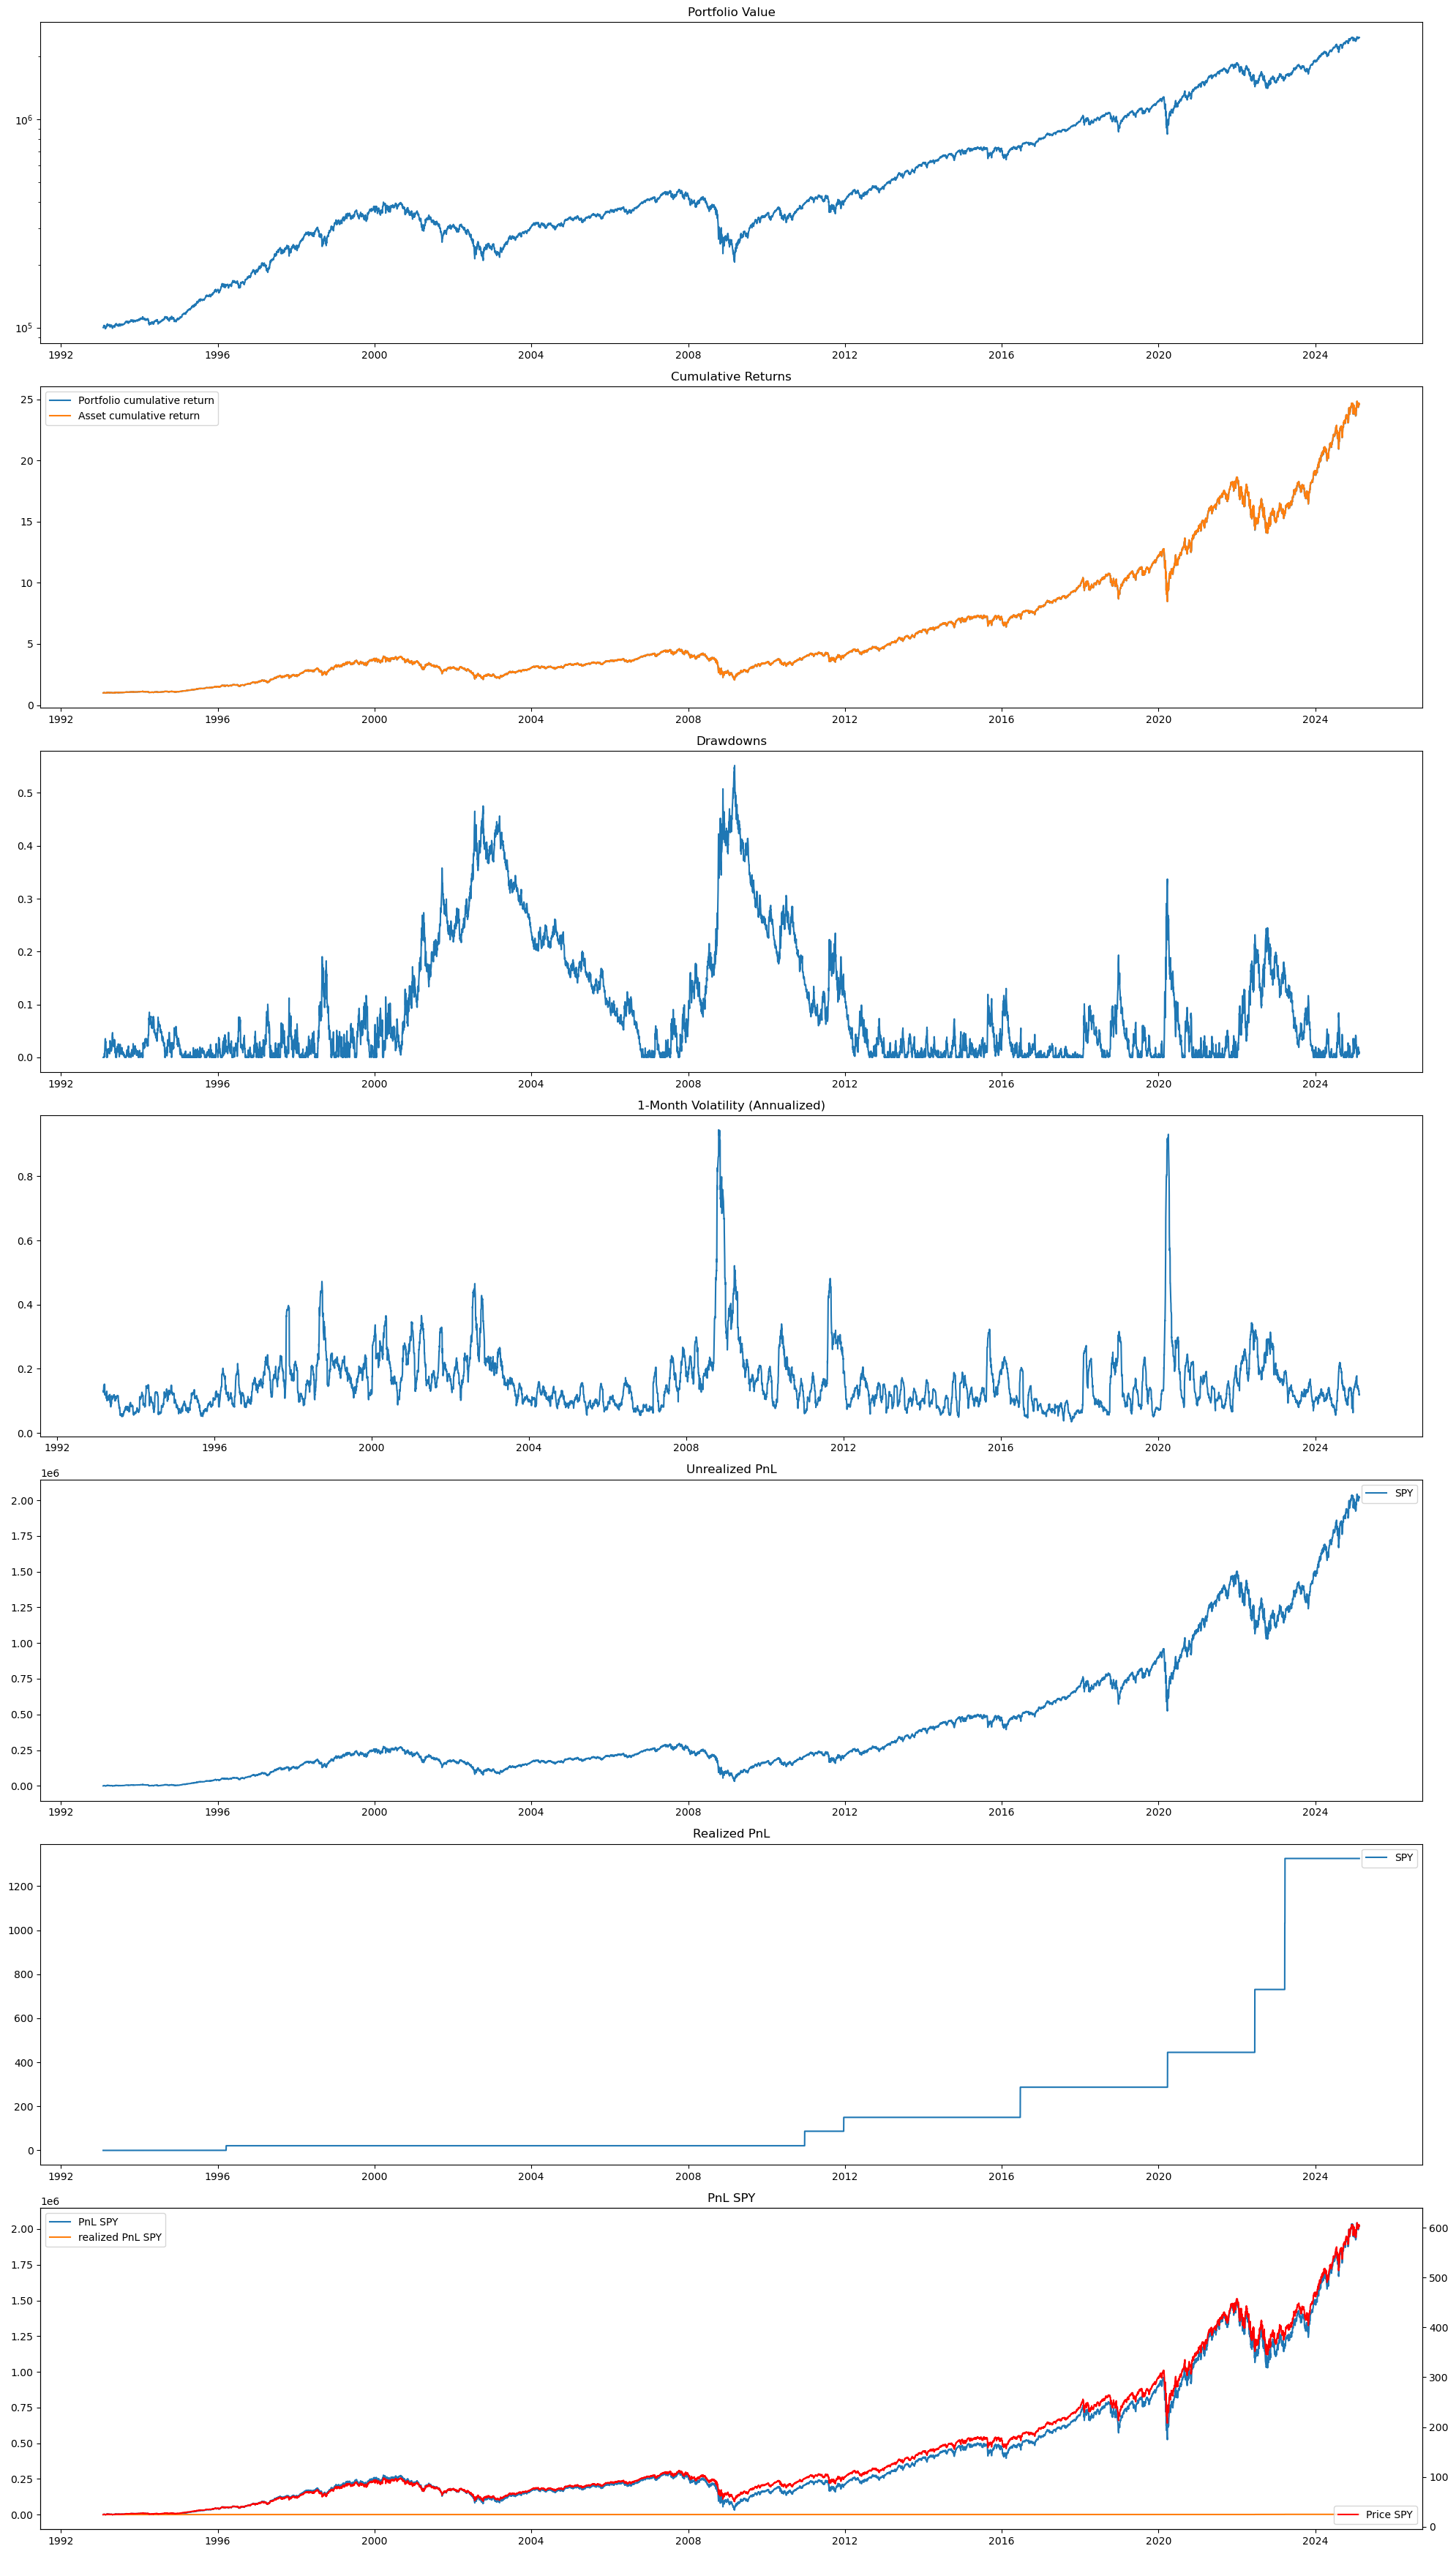

Buy and Hold Results: {'cagr': 0.09311509891534997, 'volatility': 0.17501621294416694, 'sharpe': 0.5320369887391817, 'max_drawdown': 0.4555168869794855, 'cumulative_returns': 5.043611503666076}


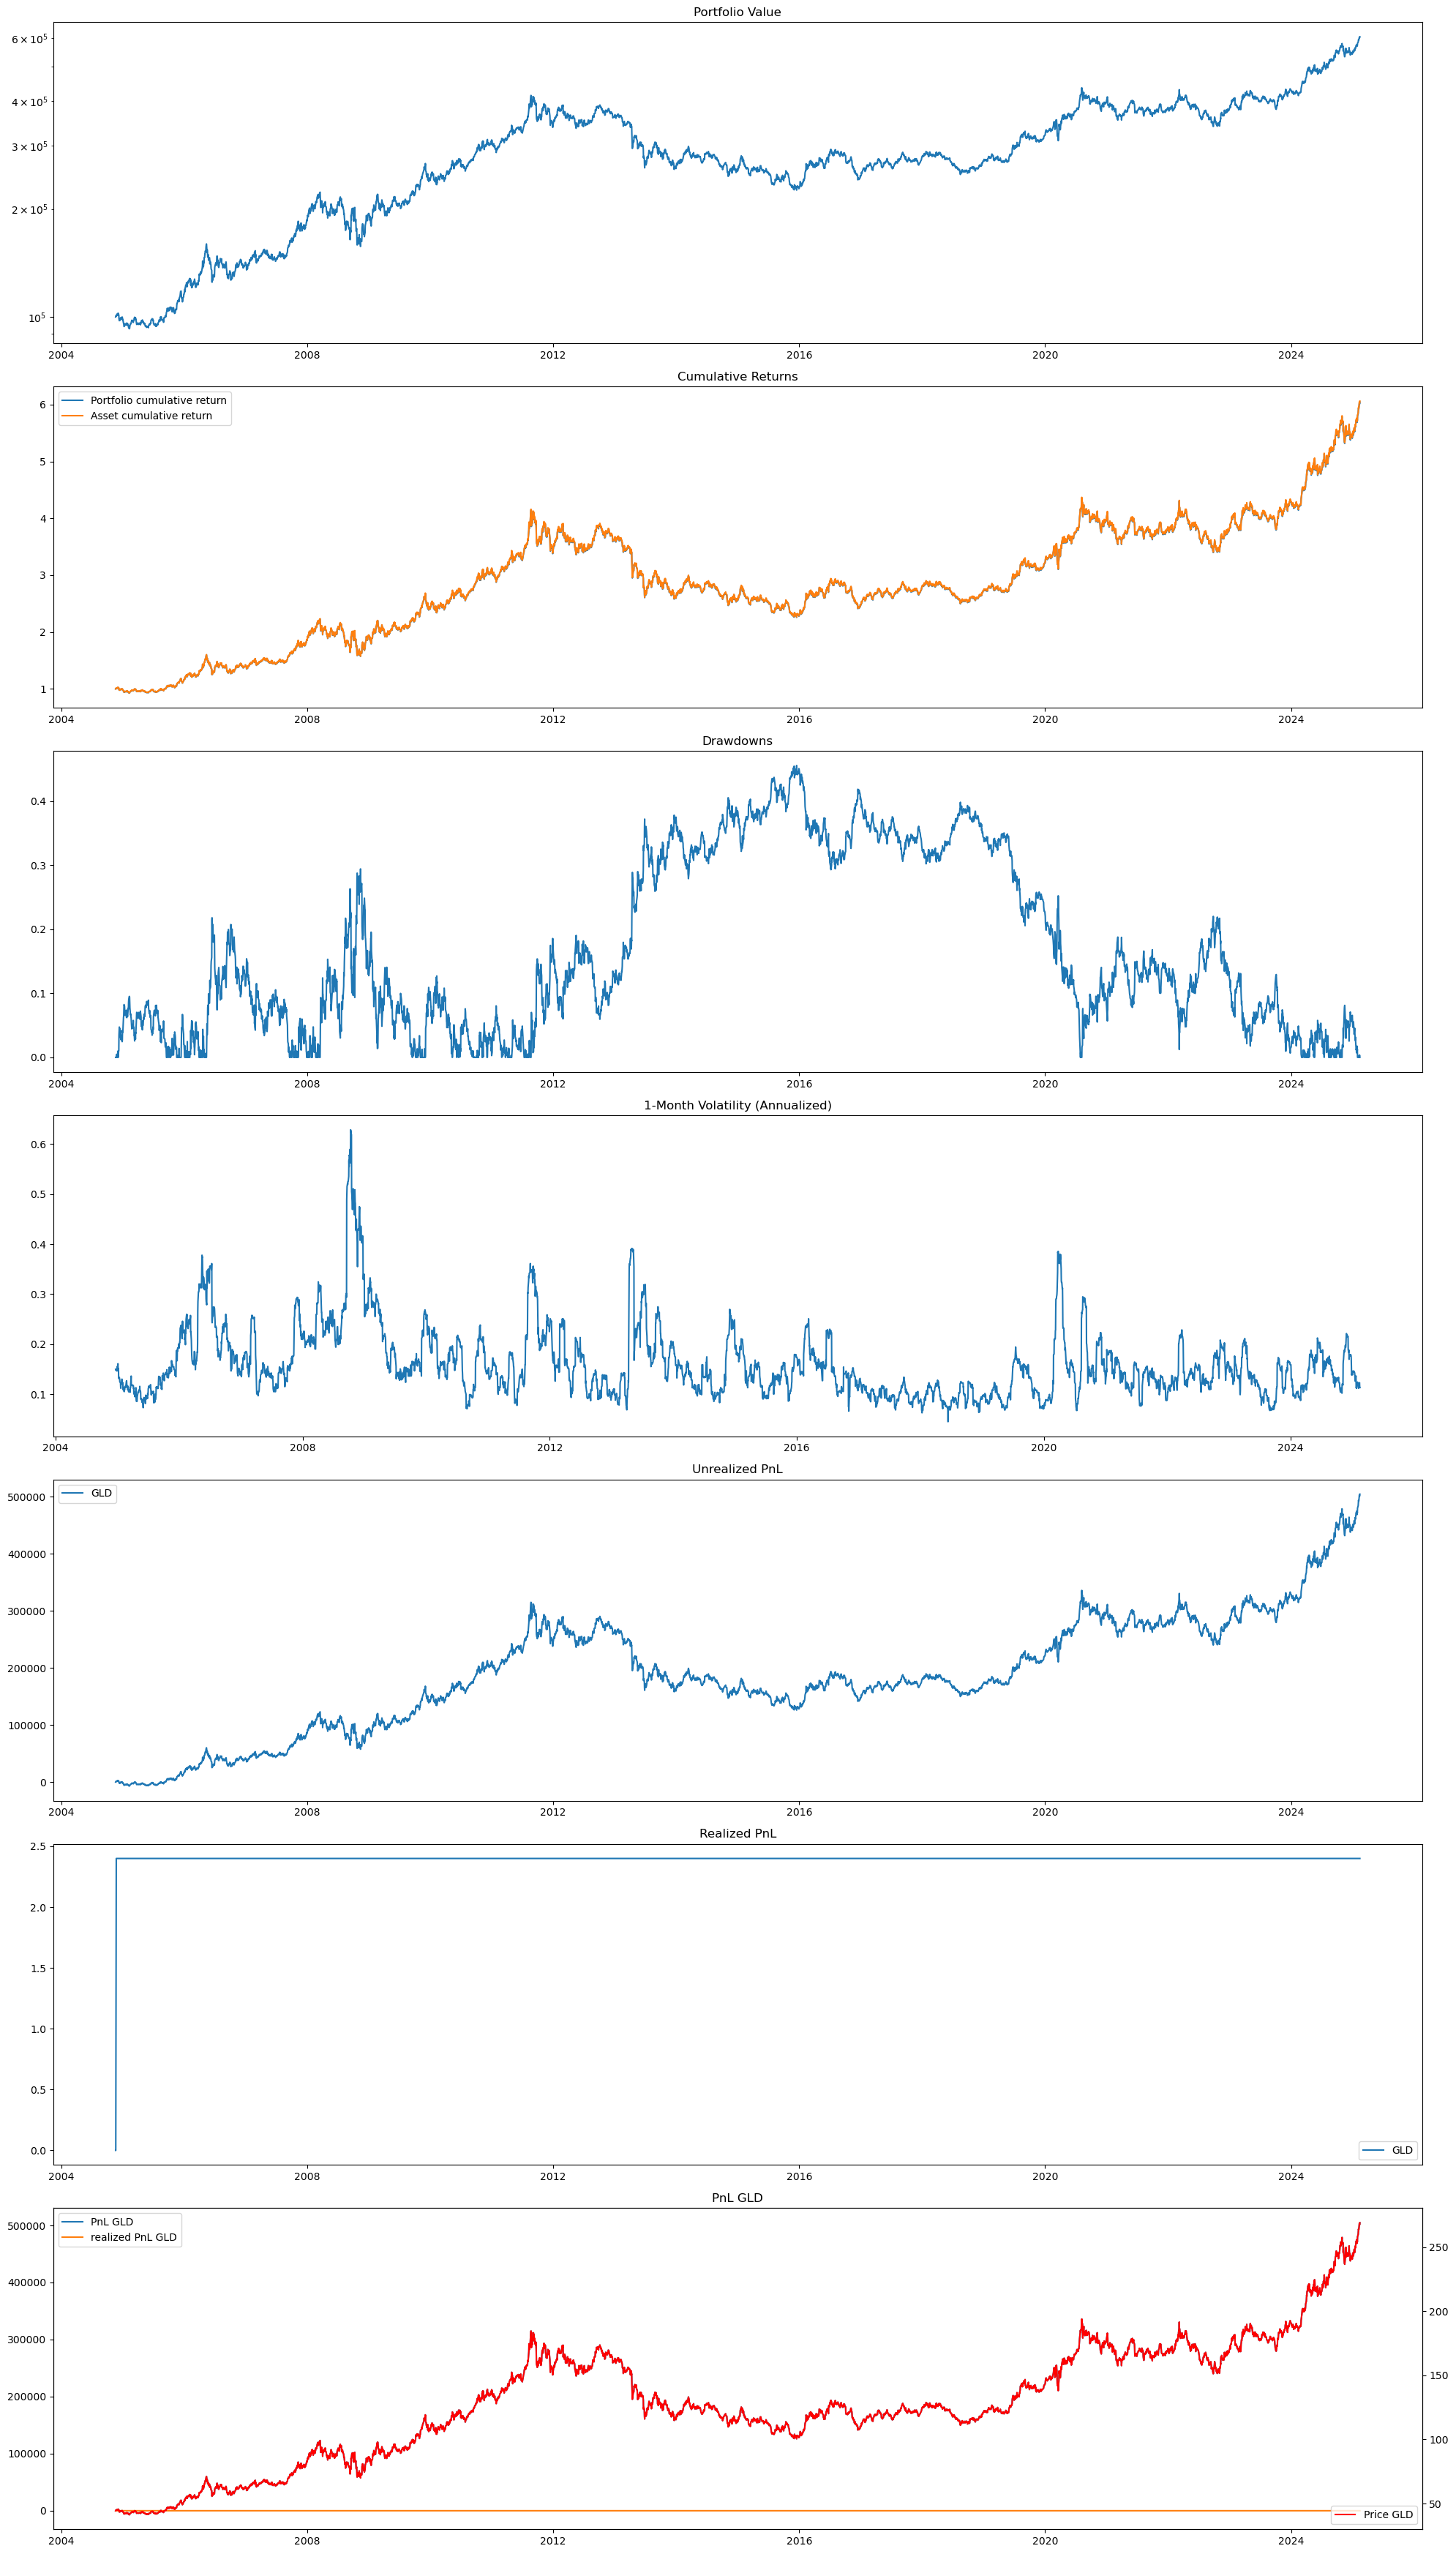

Buy and Hold Results: {'cagr': 0.03774277580776886, 'volatility': 0.14527912503105223, 'sharpe': 0.2597949003320446, 'max_drawdown': 0.4832186993012534, 'cumulative_returns': 1.3028946140699915}


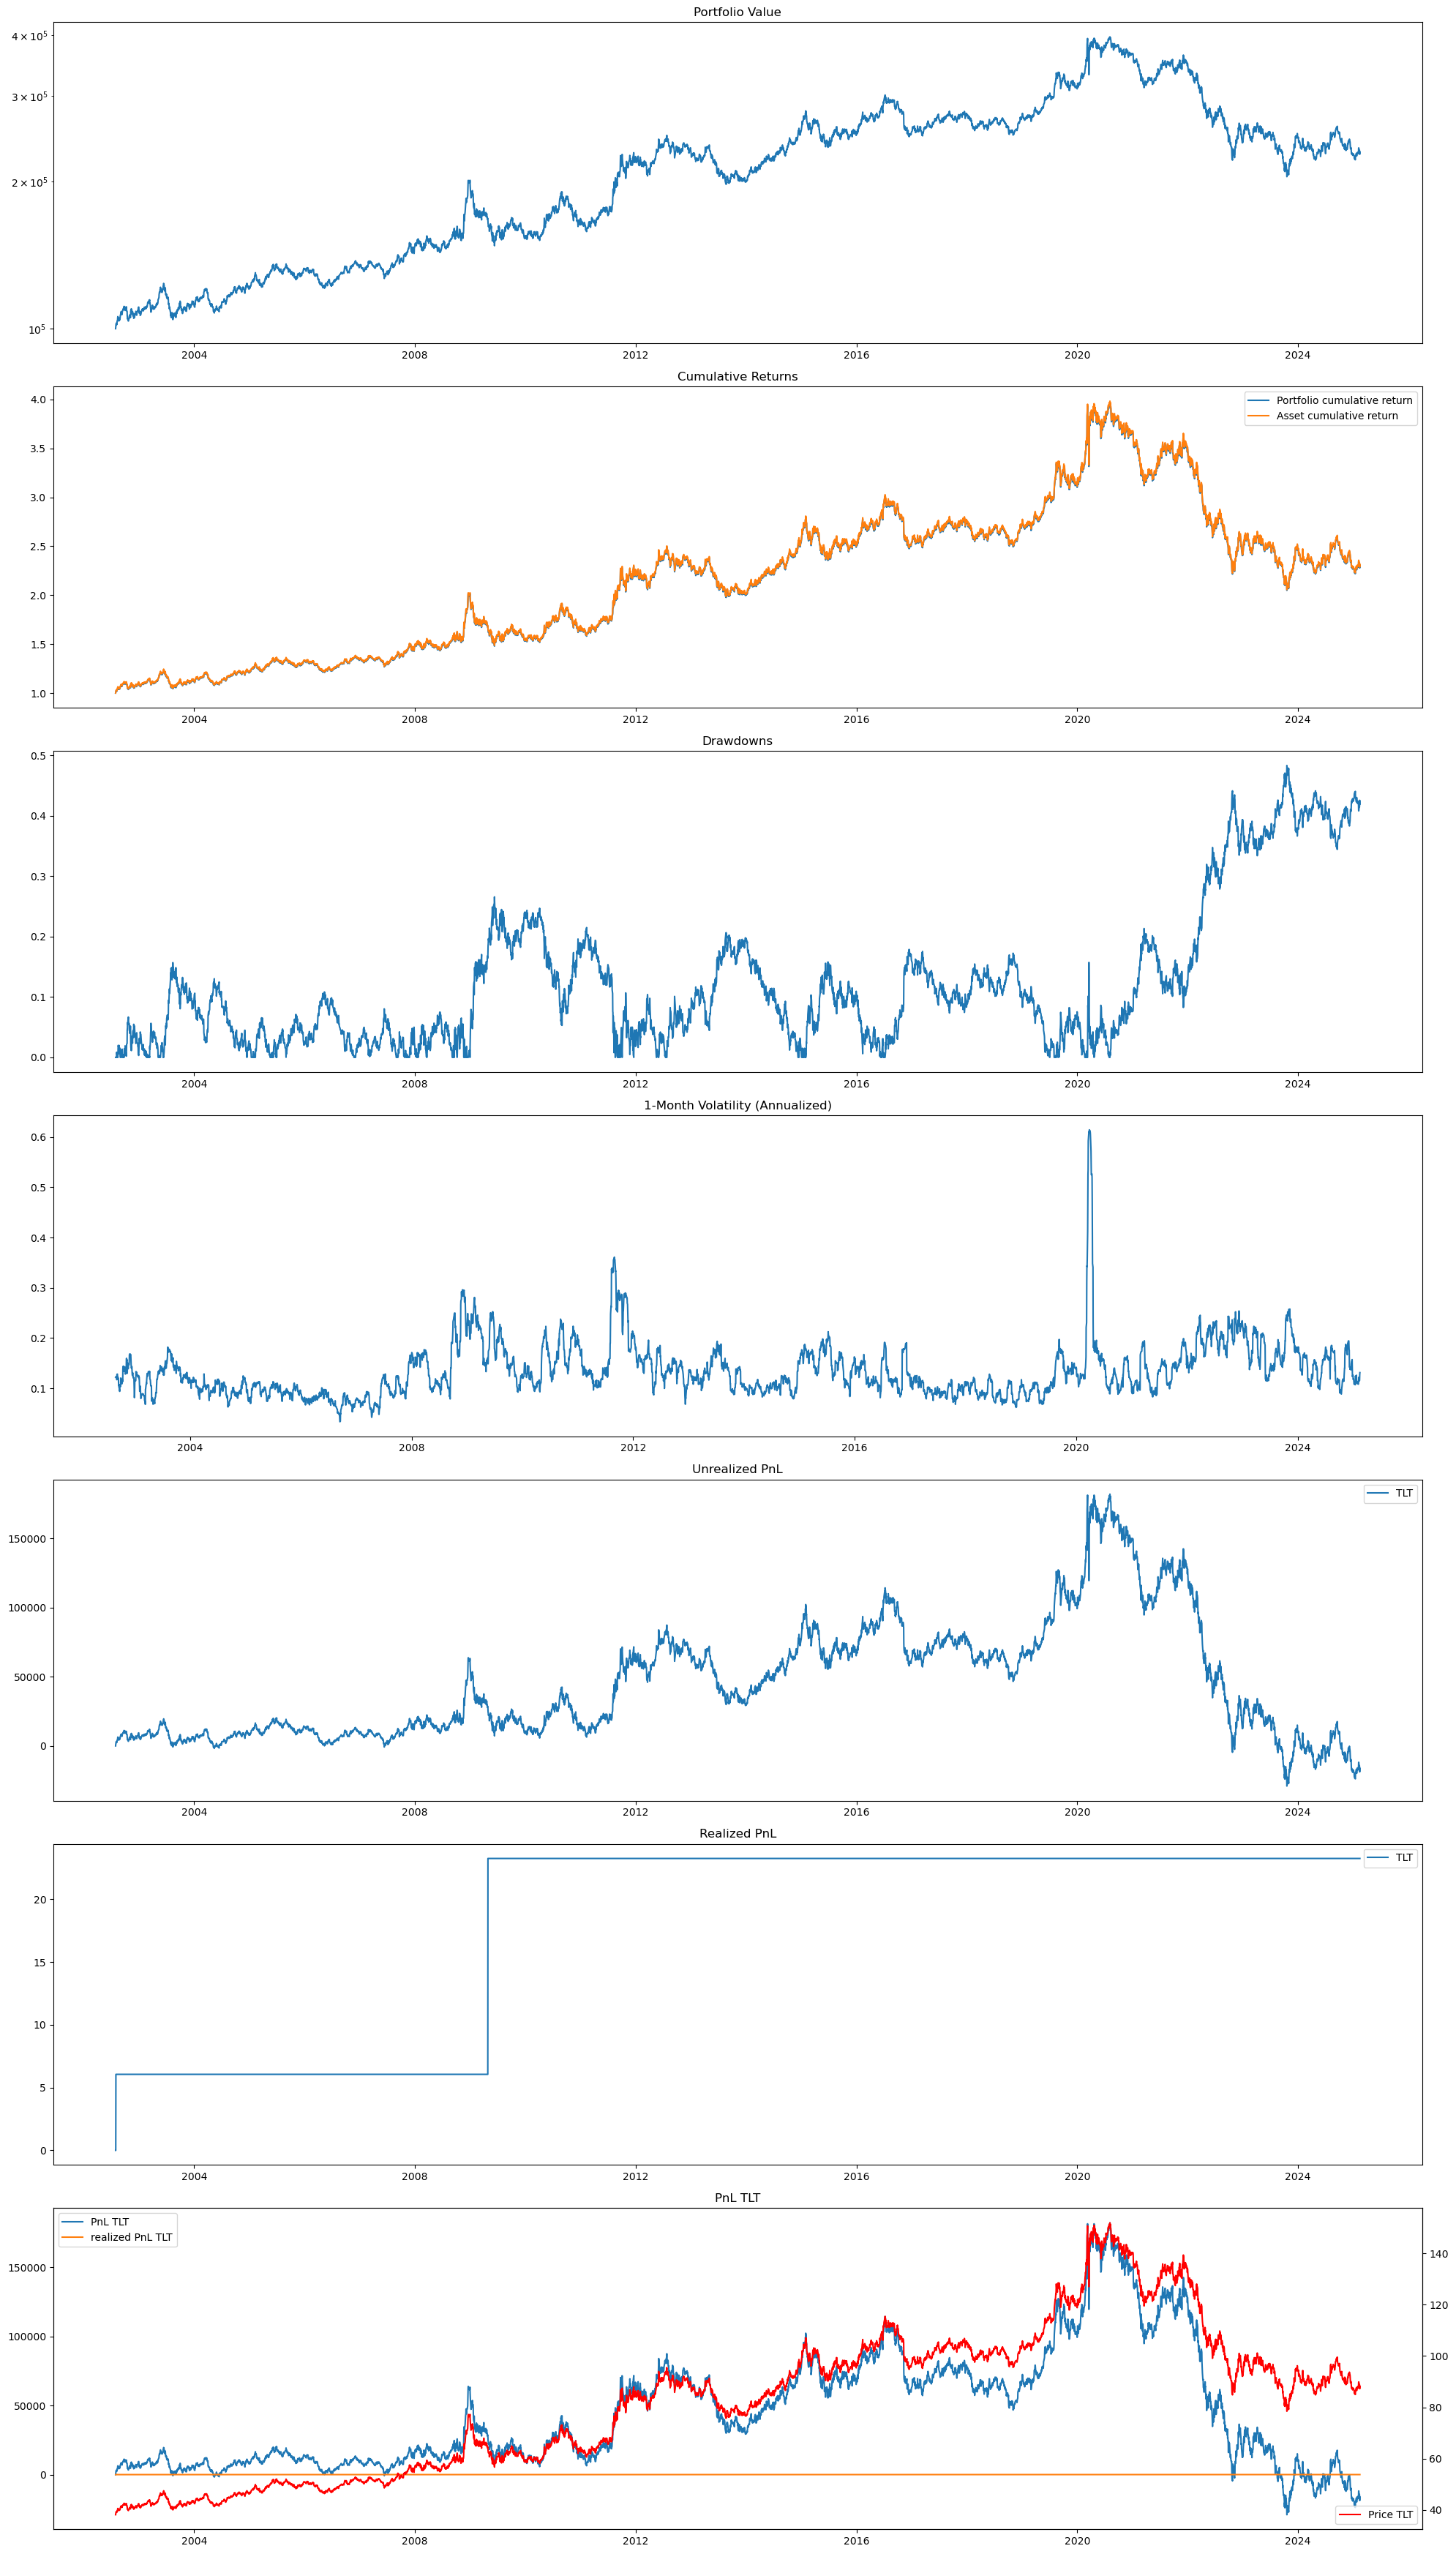

In [40]:
from strategies.buy_hold import BuyHoldStrategy

returns_logs = {
    'buy_hold': dict()
}

for ticker in ticker_list:
    df = price_data[ticker]
    # Initialize backtester
    bt = BackTester({ticker: df})

    # Example 1: Buy and Hold
    bt.add_strategy(BuyHoldStrategy, tickers=[ticker], price_data={ticker: df})
    results = bt.backtest()
    print("Buy and Hold Results:", {k: v for k, v in results.items() if k != 'returns'})
    bt.plot_results()

    returns_logs['buy_hold'][ticker] = results['returns']



## Simple MA long=252, short=21

Results for asset [SPY]: 
cagr: 0.10261699473106023
volatility: 0.13774632794645703
sharpe: 0.7449708189023244
max_drawdown: 0.337069845017723
cumulative_returns: 19.69371912172635


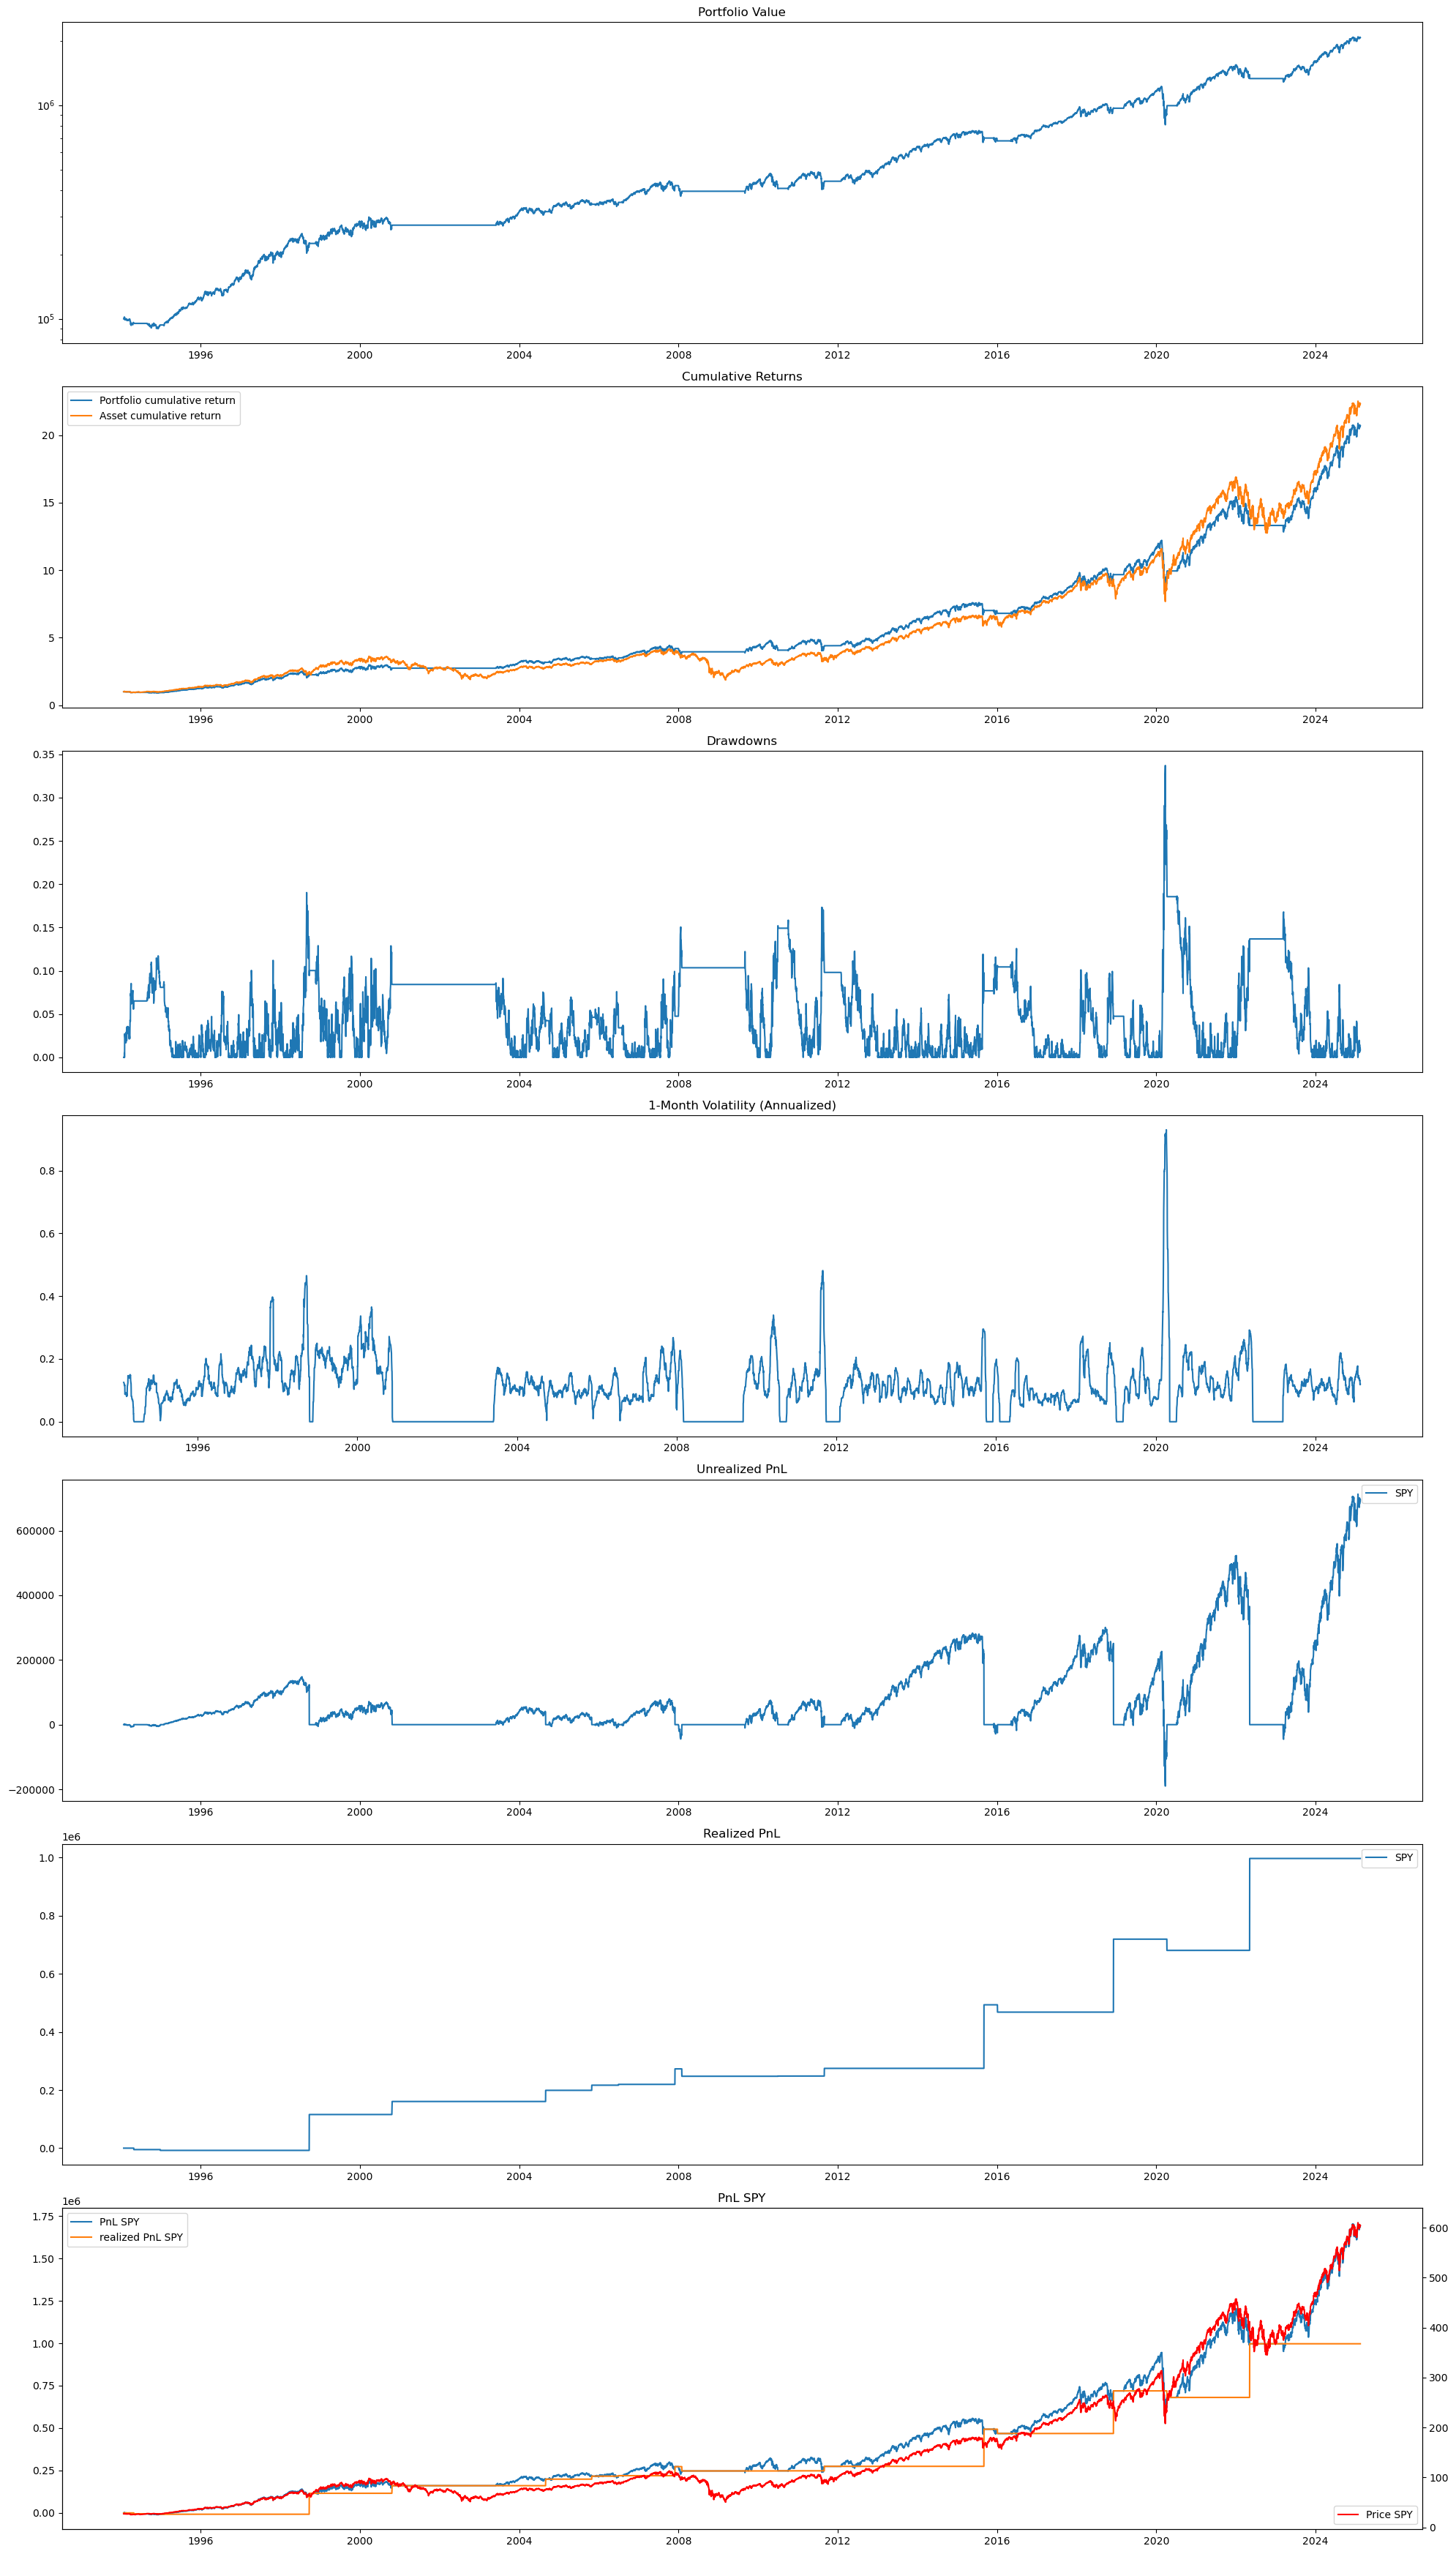

{'cagr': 0.10261699473106023,
 'volatility': 0.13774632794645703,
 'sharpe': 0.7449708189023244,
 'max_drawdown': 0.337069845017723,
 'returns':              returns
 date                
 1994-01-27  0.007244
 1994-01-28  0.002624
 1994-01-31  0.007195
 1994-02-01 -0.005195
 1994-02-02  0.006528
 ...              ...
 2025-02-07 -0.009153
 2025-02-10  0.006791
 2025-02-11  0.000761
 2025-02-12 -0.003222
 2025-02-13  0.001641
 
 [7815 rows x 1 columns],
 'cumulative_returns': 19.69371912172635}

Results for asset [GLD]: 
cagr: 0.08043169762158642
volatility: 0.1451698343836751
sharpe: 0.5540524170401016
max_drawdown: 0.3423192080802749
cumulative_returns: 3.4199272934776532


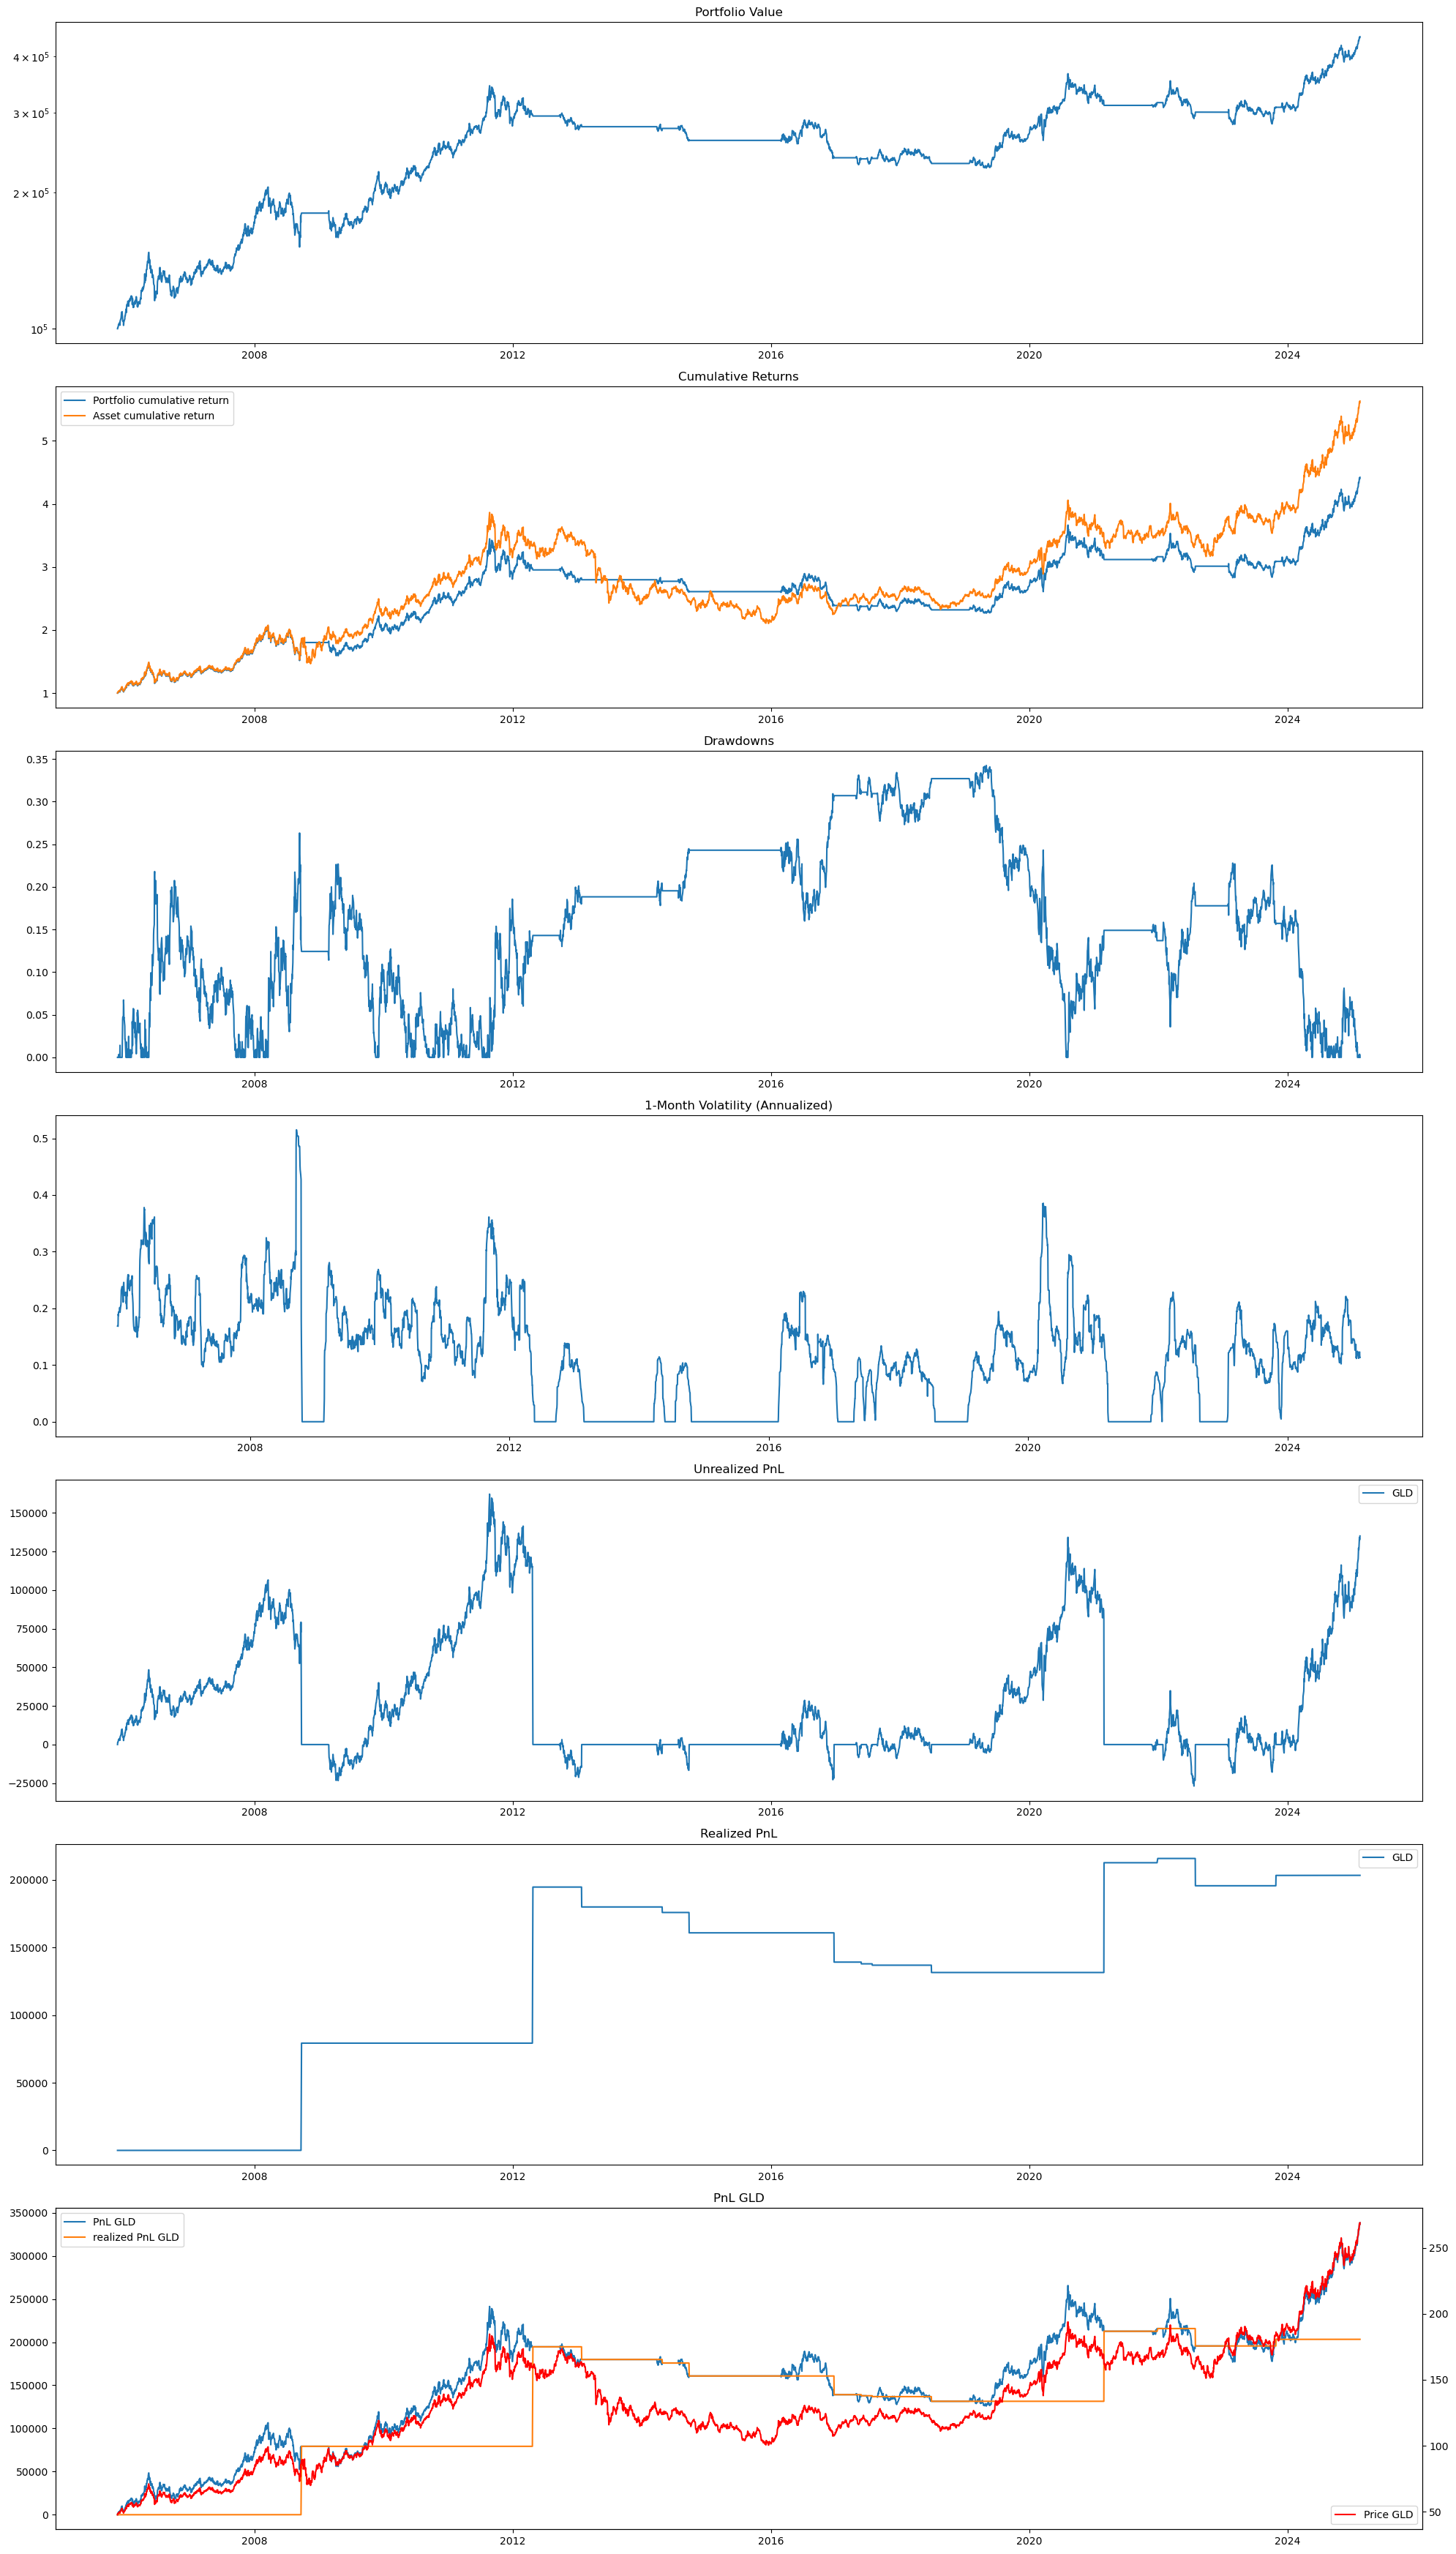

{'cagr': 0.08043169762158642,
 'volatility': 0.1451698343836751,
 'sharpe': 0.5540524170401016,
 'max_drawdown': 0.3423192080802749,
 'returns':              returns
 date                
 2005-11-17  0.005211
 2005-11-18 -0.000416
 2005-11-21  0.011040
 2005-11-22  0.006799
 2005-11-23 -0.003479
 ...              ...
 2025-02-07  0.001784
 2025-02-10  0.016938
 2025-02-11 -0.003652
 2025-02-12  0.001047
 2025-02-13  0.004782
 
 [4840 rows x 1 columns],
 'cumulative_returns': 3.4199272934776532}

Results for asset [TLT]: 
cagr: 0.020307409221812067
volatility: 0.1054791468929323
sharpe: 0.19252534571999633
max_drawdown: 0.26987739336271654
cumulative_returns: 0.541312155990084


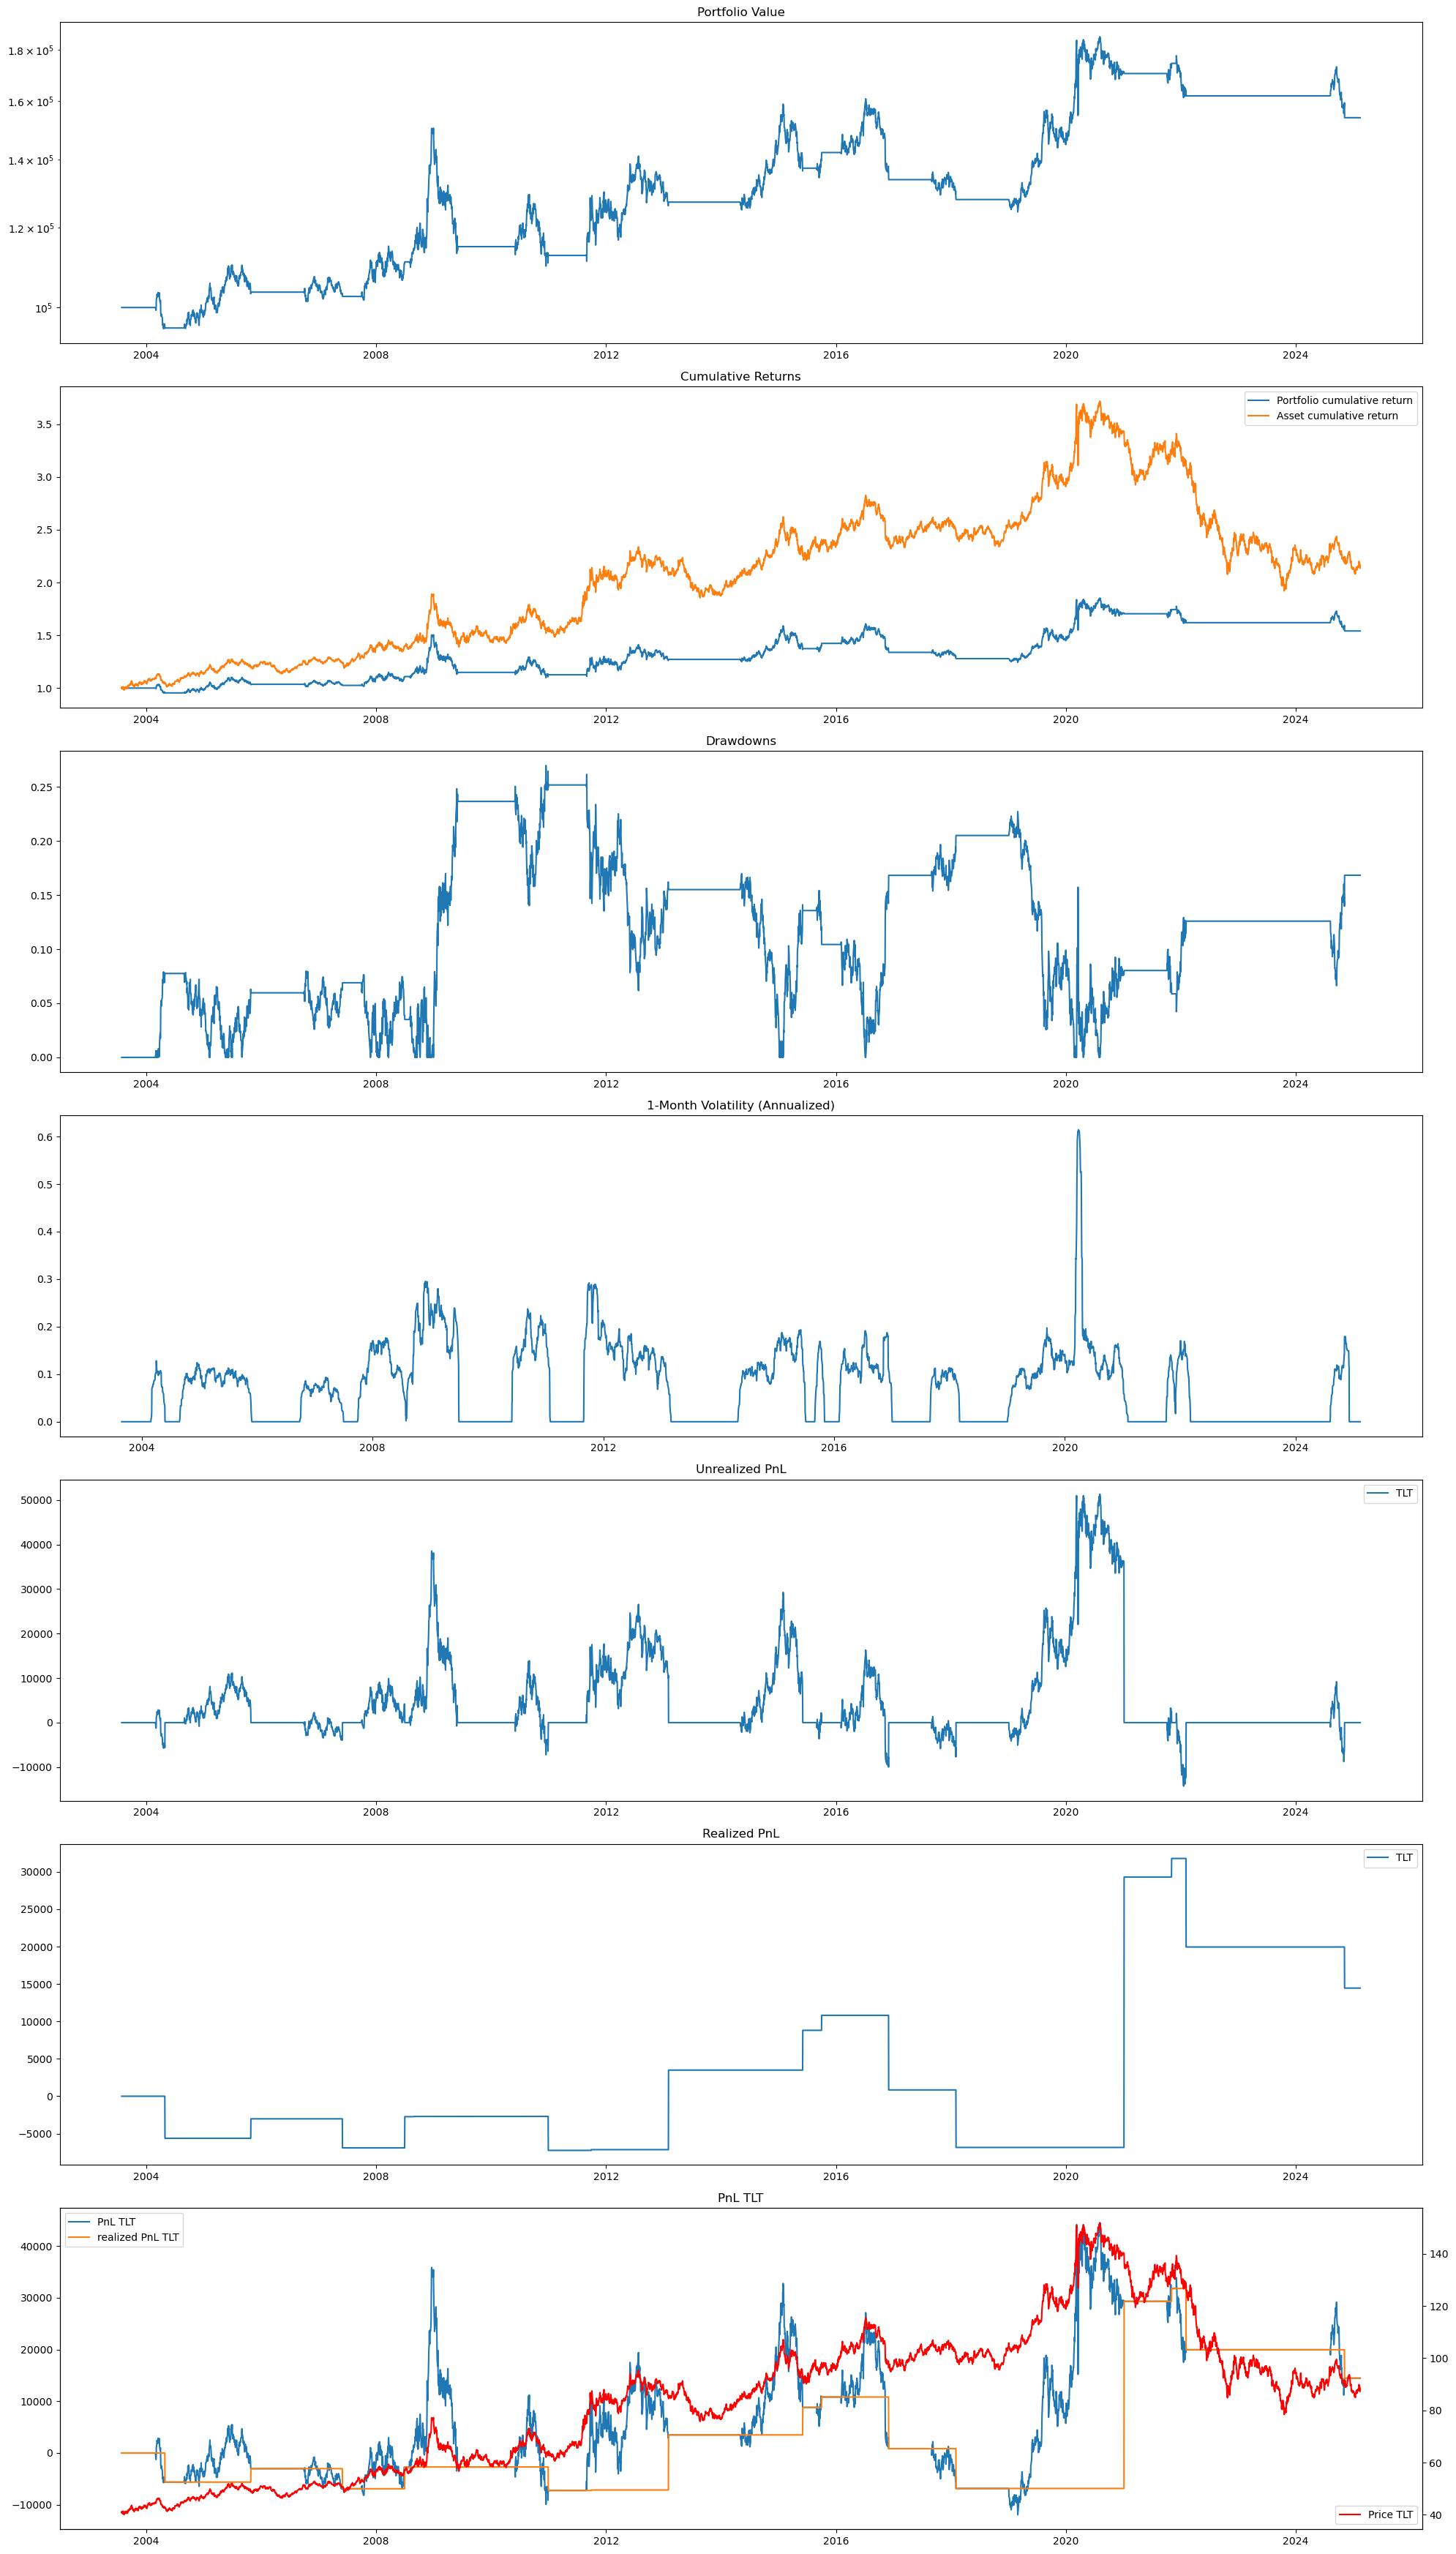

{'cagr': 0.020307409221812067,
 'volatility': 0.1054791468929323,
 'sharpe': 0.19252534571999633,
 'max_drawdown': 0.26987739336271654,
 'returns':             returns
 date               
 2003-07-30      0.0
 2003-07-31      0.0
 2003-08-01      0.0
 2003-08-04      0.0
 2003-08-05      0.0
 ...             ...
 2025-02-07      0.0
 2025-02-10      0.0
 2025-02-11      0.0
 2025-02-12      0.0
 2025-02-13      0.0
 
 [5422 rows x 1 columns],
 'cumulative_returns': 0.541312155990084}

In [41]:
from strategies.trend_following import MovingAverageCrossoverStrategy

def backtest_strategy(ticker, df, short_window, long_window, verbose=False):
    tl = [ticker]
    pda = {ticker: df}

    bt = BackTester(pda)
    bt.add_strategy(MovingAverageCrossoverStrategy, tickers=tl, price_data=pda, short_window=short_window, long_window=long_window, rebalance_period=21)
    results = bt.backtest()
    if verbose:
        print(f"Results for asset [{ticker}]: ")
        for key in results:
            if key == 'returns': continue
            print(f"{key}: {results[key]}")
        bt.plot_results()

    return results

returns_logs['reference_SMA'] = dict()
for ticker in ticker_list:
    results = backtest_strategy(ticker, price_data[ticker], 21, 252, verbose=True)
    display(results)

    returns_logs['reference_SMA'][ticker] = results['returns']




## Params optimization

Test optimization of long_window and short_window.

We split the data into 5 time periods and do time series cross validation. 

The steps are:
- optimize the parameters for time period 1
- use the optimized parameters to predict time period 2
- optimize the parameters for time period 1 and 2
- use the optimized parameters to predict time period 3
...


In [42]:
import optuna
from optuna.samplers import TPESampler


def optimize_params(ticker, df, n_trials=100):
    def objective(trial):
        long_window = trial.suggest_int("long_window", 50, 500)
        short_window = trial.suggest_int("short_window", 5, 252)

        if long_window < short_window:
            return -1
        
        return backtest_strategy(
            ticker=ticker,
            df=df,
            short_window=short_window,
            long_window=long_window,
        )['sharpe']
    
    study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    return study.best_params



### Oracle Params (Cheating)

In [43]:
oracle_params = dict()
for ticker in ticker_list:
    df = price_data[ticker]

    best_params = optimize_params(ticker, df, 100)
    # print(best_params)

    oracle_params[ticker] = best_params





[I 2025-02-22 20:45:39,769] A new study created in memory with name: no-name-65a63d23-b435-4606-8c05-2d49de76593f


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 20:45:39,793] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 20:45:43,846] Trial 1 finished with value: 0.7138753403846456 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.7138753403846456.
[I 2025-02-22 20:45:48,048] Trial 2 finished with value: 0.6952984182180548 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.7138753403846456.
[I 2025-02-22 20:45:48,050] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.7138753403846456.
[I 2025-02-22 20:45:52,207] Trial 4 finished with value: 0.7457038961433311 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 0.7457038961433311.
[I 2025-02-22 20:45:52,212] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is t

[I 2025-02-22 20:51:49,936] A new study created in memory with name: no-name-deffe6c4-8b60-40dc-89f7-f05e7b8e9603


[I 2025-02-22 20:51:49,932] Trial 99 finished with value: 0.6979250527015473 and parameters: {'long_window': 480, 'short_window': 201}. Best is trial 62 with value: 0.764551290071342.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 20:51:49,945] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 20:51:52,497] Trial 1 finished with value: 0.458525852484561 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.458525852484561.
[I 2025-02-22 20:51:55,070] Trial 2 finished with value: 0.5363493421414184 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.5363493421414184.
[I 2025-02-22 20:51:55,073] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.5363493421414184.
[I 2025-02-22 20:51:59,315] Trial 4 finished with value: 0.4888151869504231 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.5363493421414184.
[I 2025-02-22 20:51:59,318] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is tri

[I 2025-02-22 20:55:32,079] A new study created in memory with name: no-name-170e7005-866d-4275-bbd1-248c2f1d9fc4


[I 2025-02-22 20:55:32,076] Trial 99 finished with value: 0.5504575297279171 and parameters: {'long_window': 96, 'short_window': 48}. Best is trial 7 with value: 0.7285155181887887.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 20:55:32,088] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 20:55:34,866] Trial 1 finished with value: 0.06143452132089828 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.06143452132089828.
[I 2025-02-22 20:55:37,612] Trial 2 finished with value: 0.15801992437228335 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.15801992437228335.
[I 2025-02-22 20:55:37,614] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.15801992437228335.
[I 2025-02-22 20:55:40,335] Trial 4 finished with value: 0.02986966860114161 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.15801992437228335.
[I 2025-02-22 20:55:40,337] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Be

#### Results

SPY
{'long_window': 485, 'short_window': 101}
Results for asset [SPY]: 
cagr: 0.11483662057246002
volatility: 0.15020132993529361
sharpe: 0.764551290071342
max_drawdown: 0.33706991665848574
cumulative_returns: 25.341818037739714


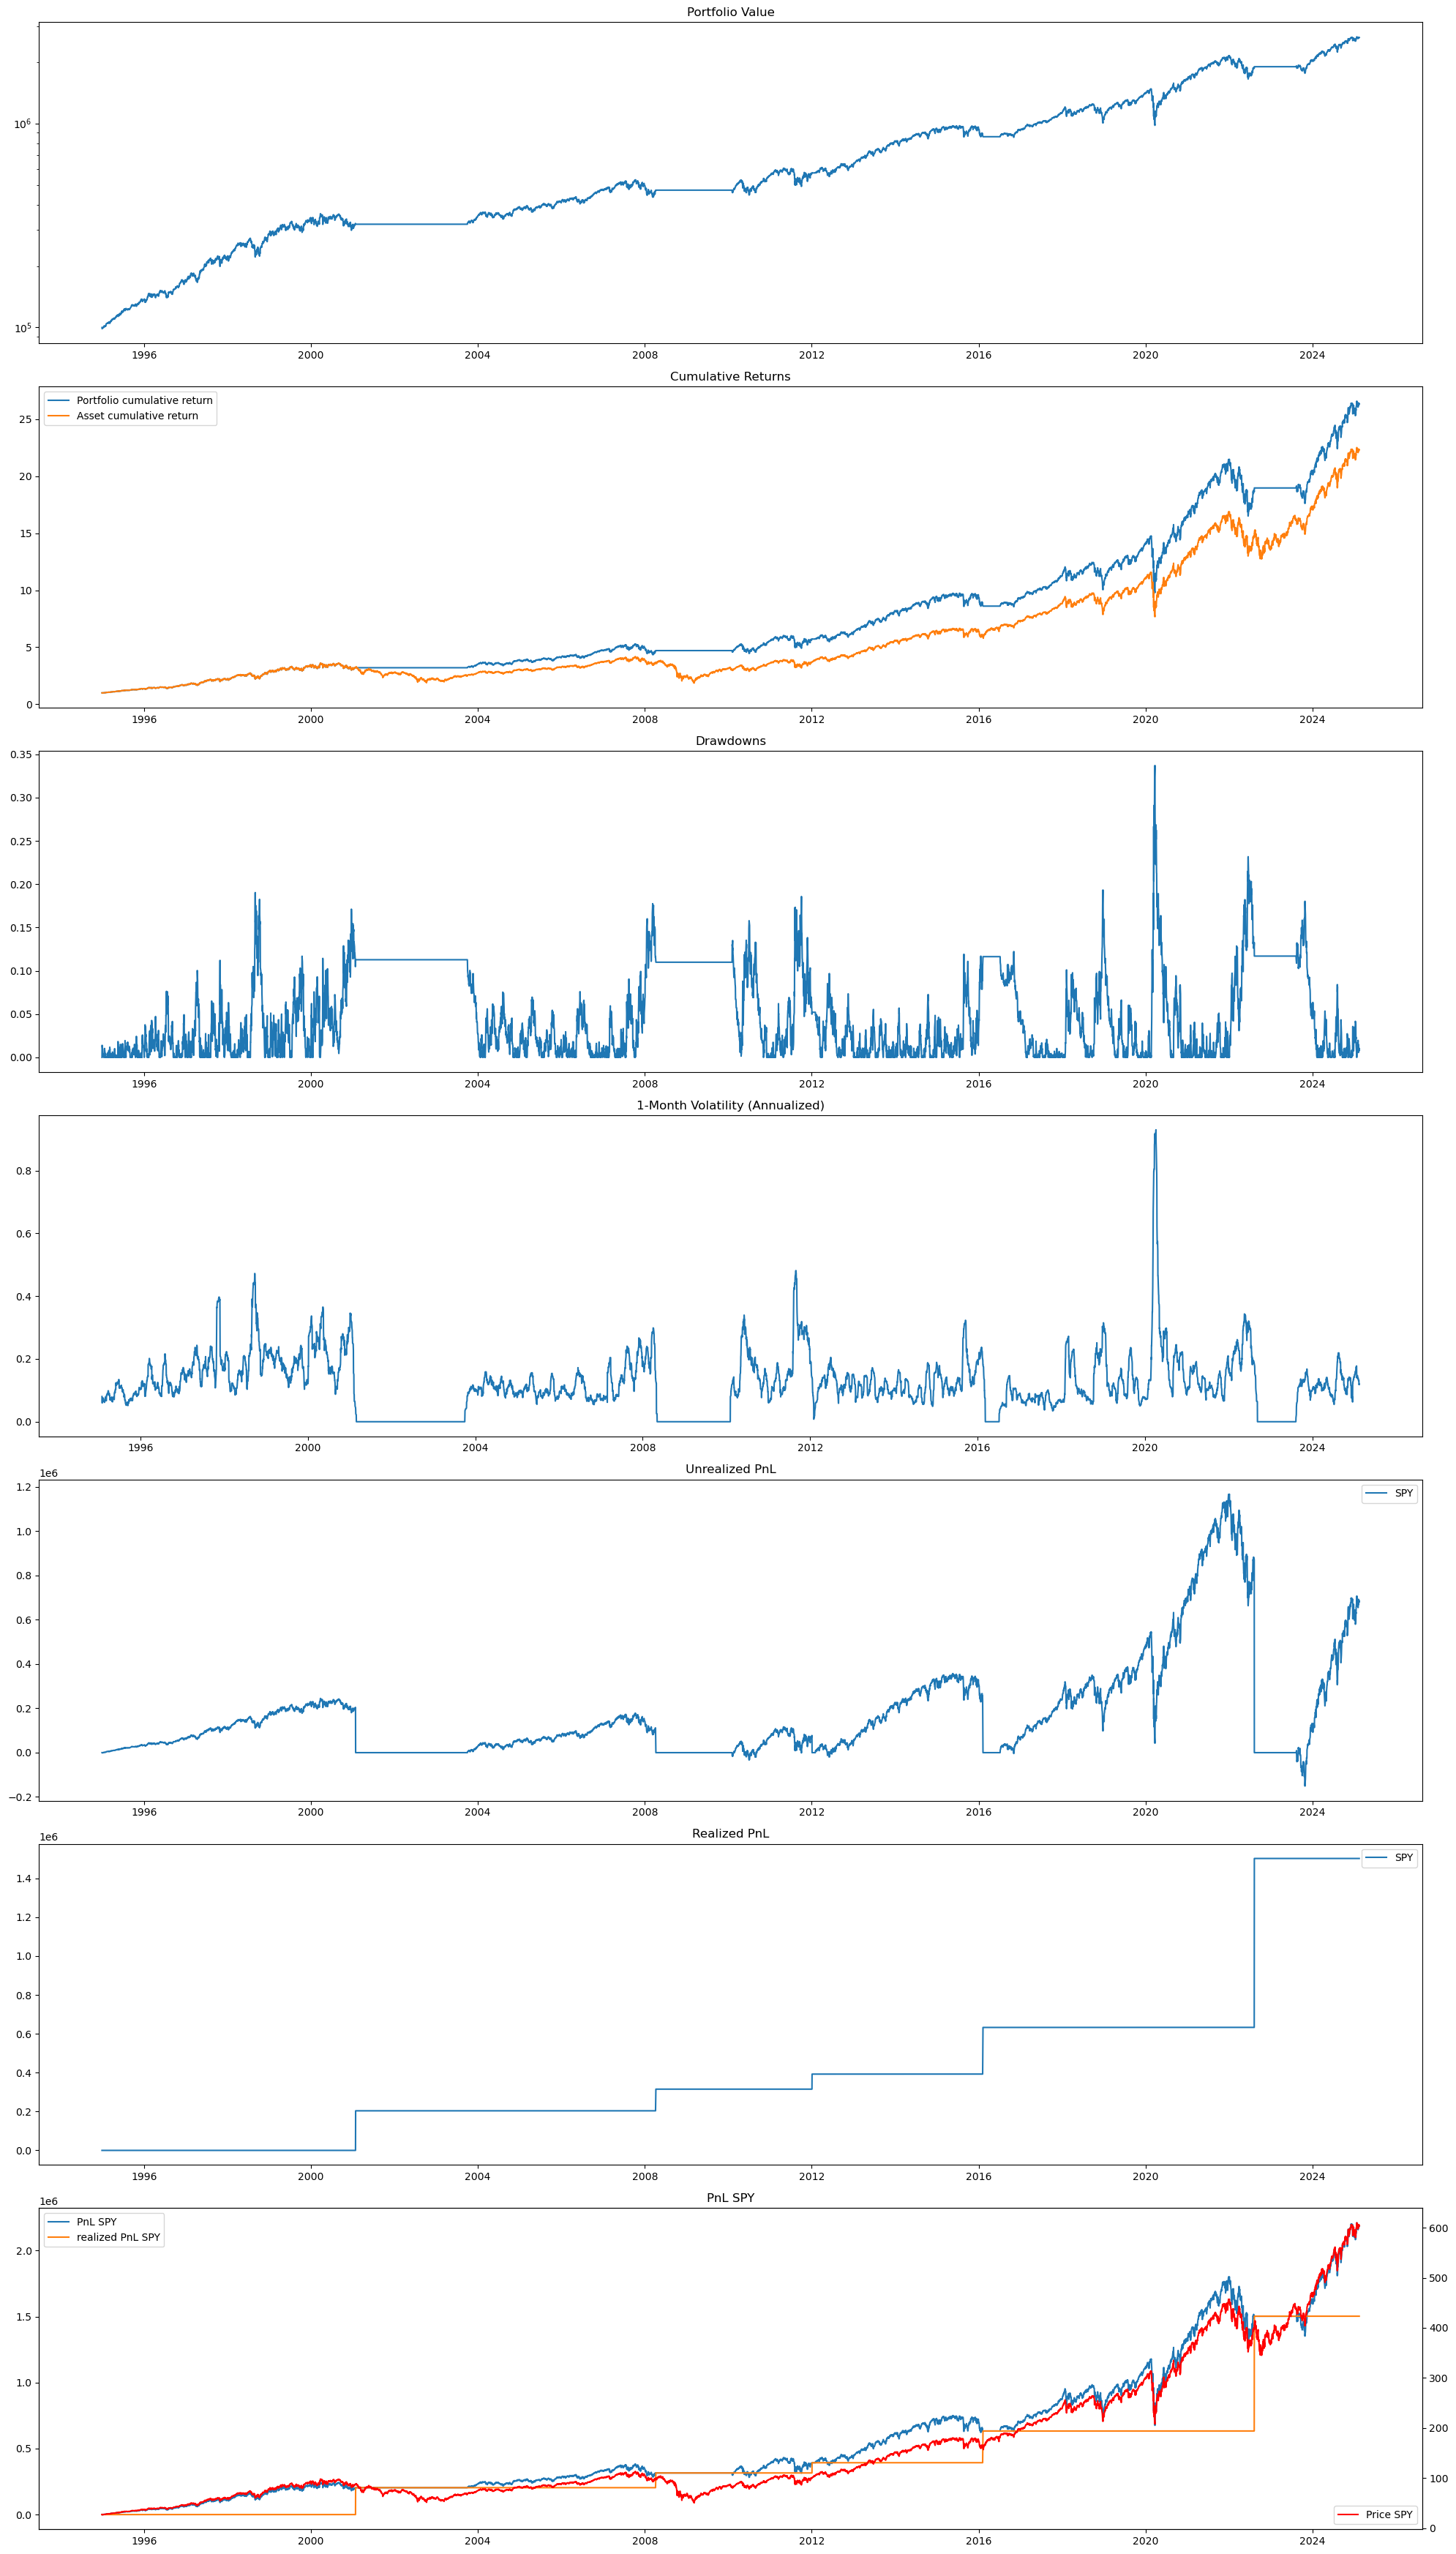

GLD
{'long_window': 132, 'short_window': 50}
Results for asset [GLD]: 
cagr: 0.09966154265442184
volatility: 0.1368008507247685
sharpe: 0.7285155181887887
max_drawdown: 0.21794155253238065
cumulative_returns: 5.4900248978940045


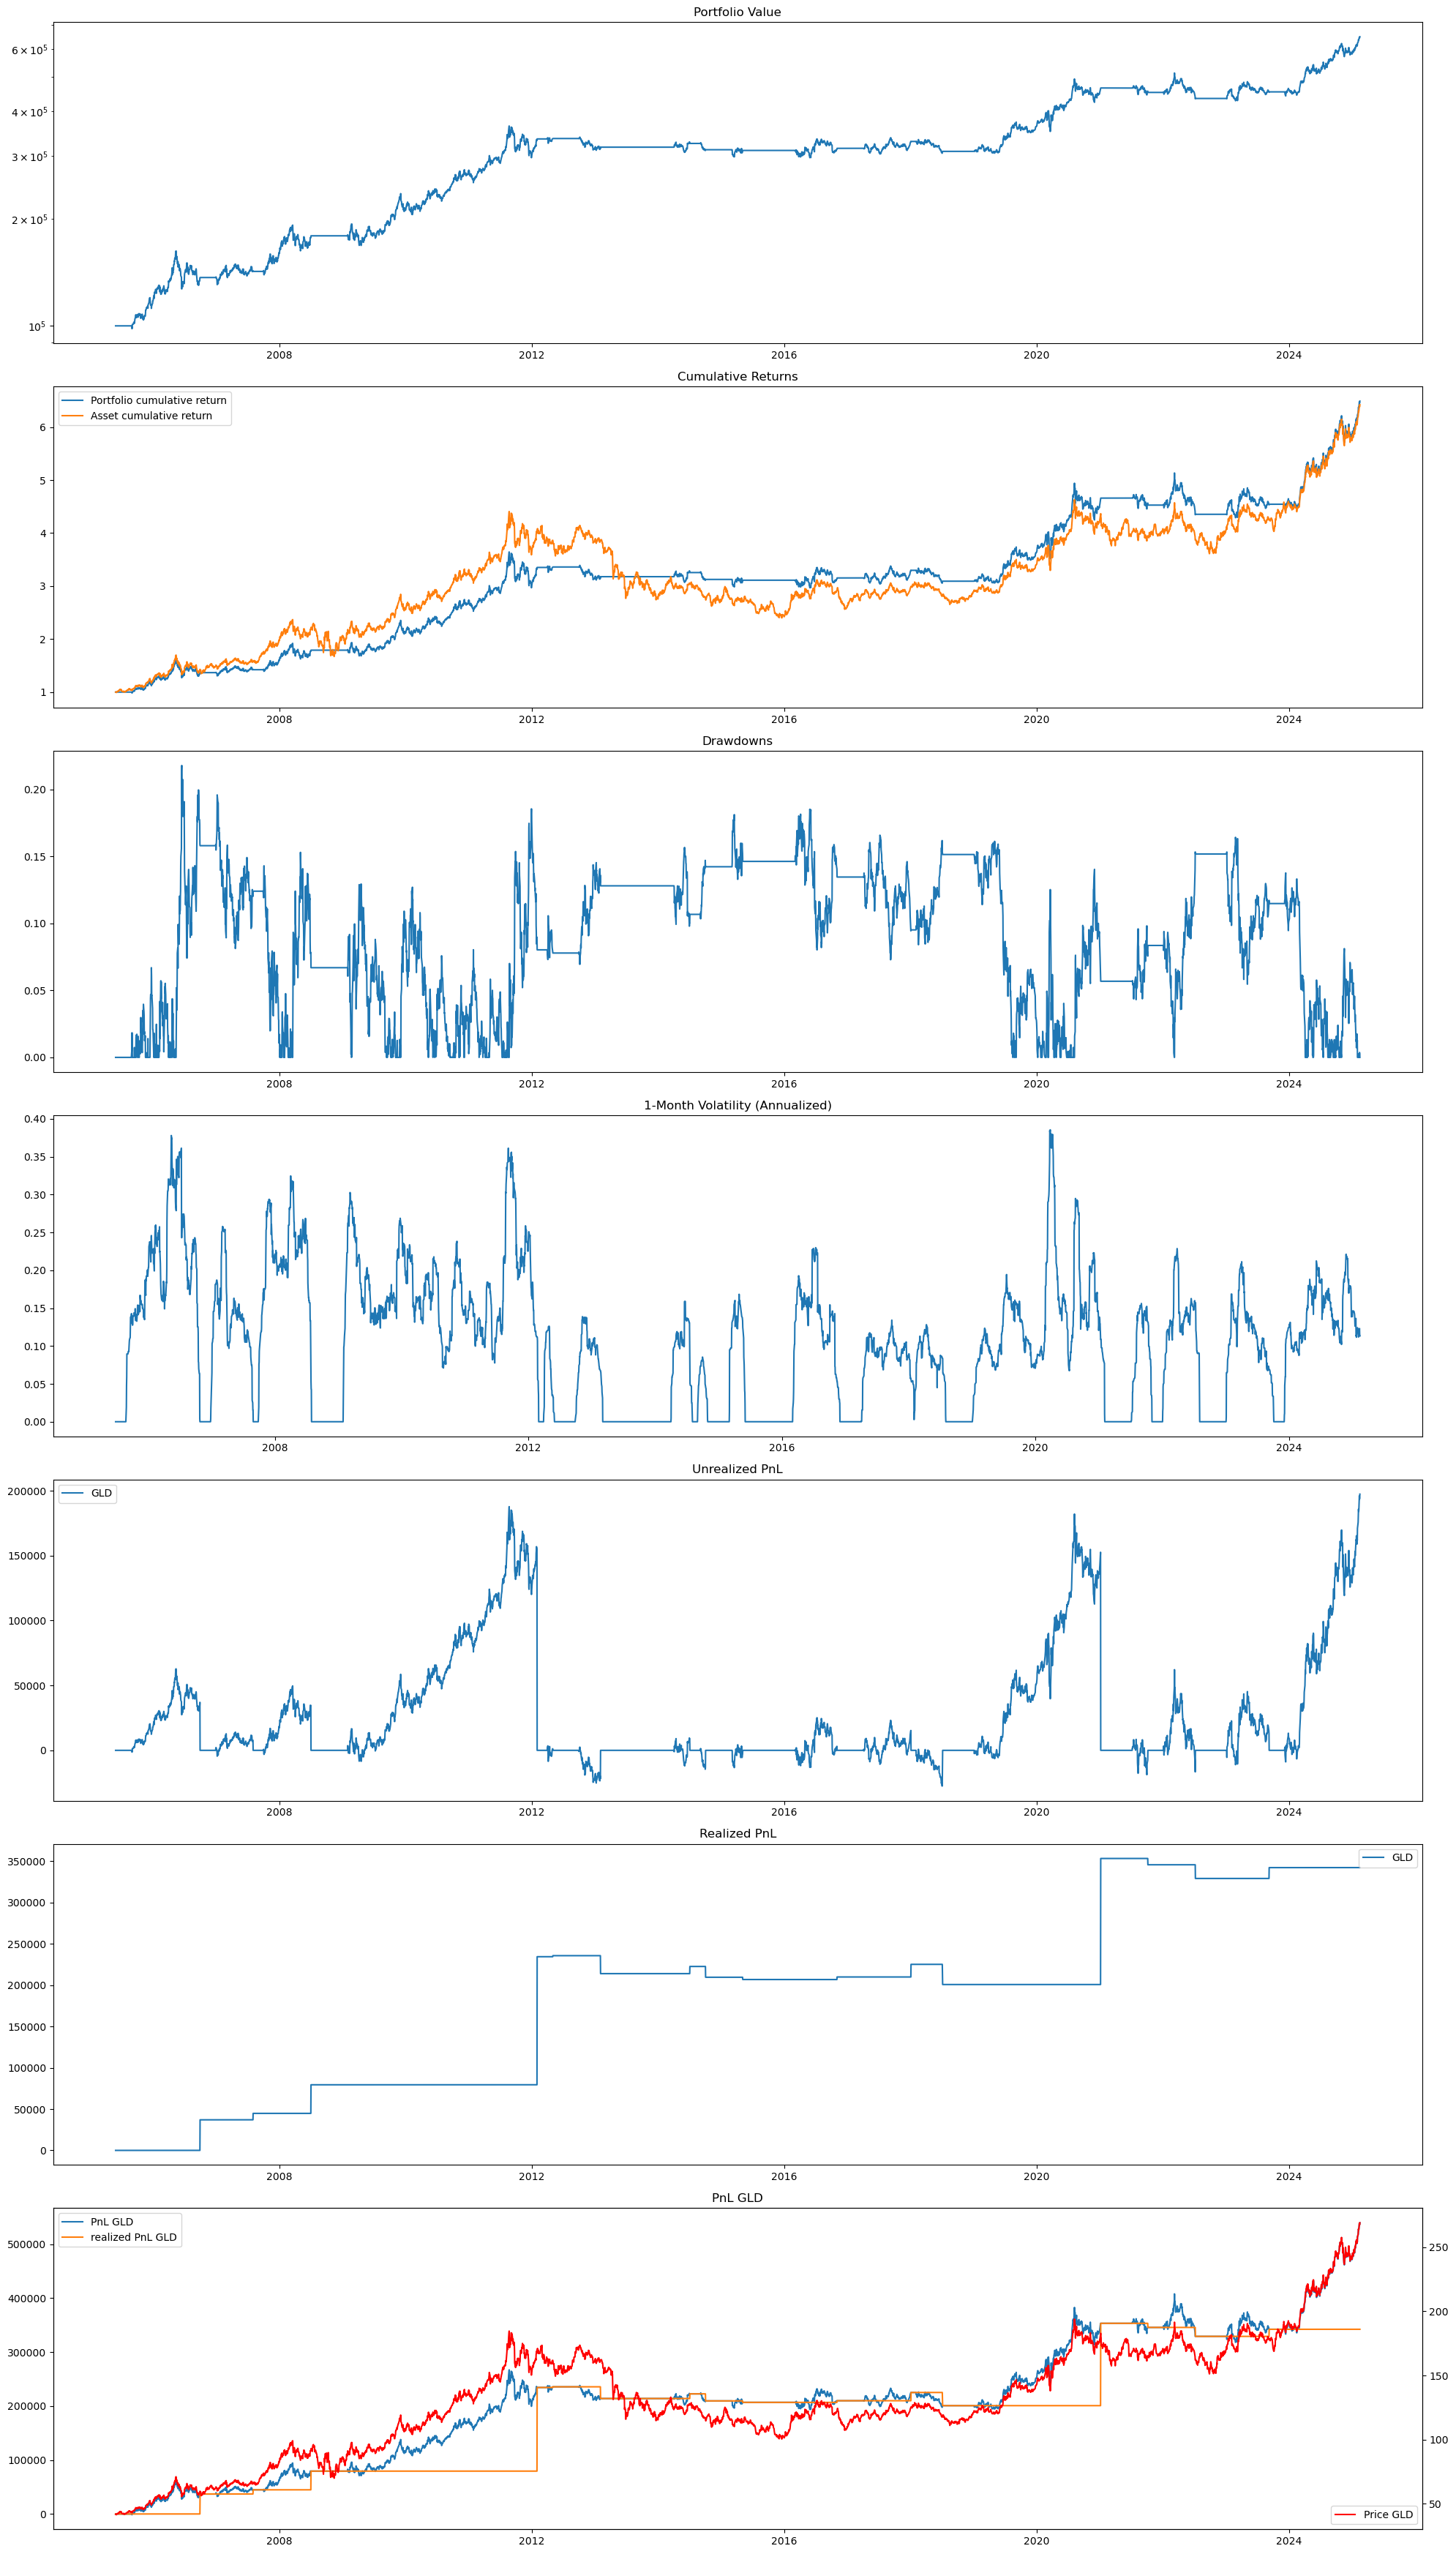

TLT
{'long_window': 82, 'short_window': 14}
Results for asset [TLT]: 
cagr: 0.0494337964459346
volatility: 0.10718520241193255
sharpe: 0.46119982360952566
max_drawdown: 0.17375905901163824
cumulative_returns: 1.9180021736066837


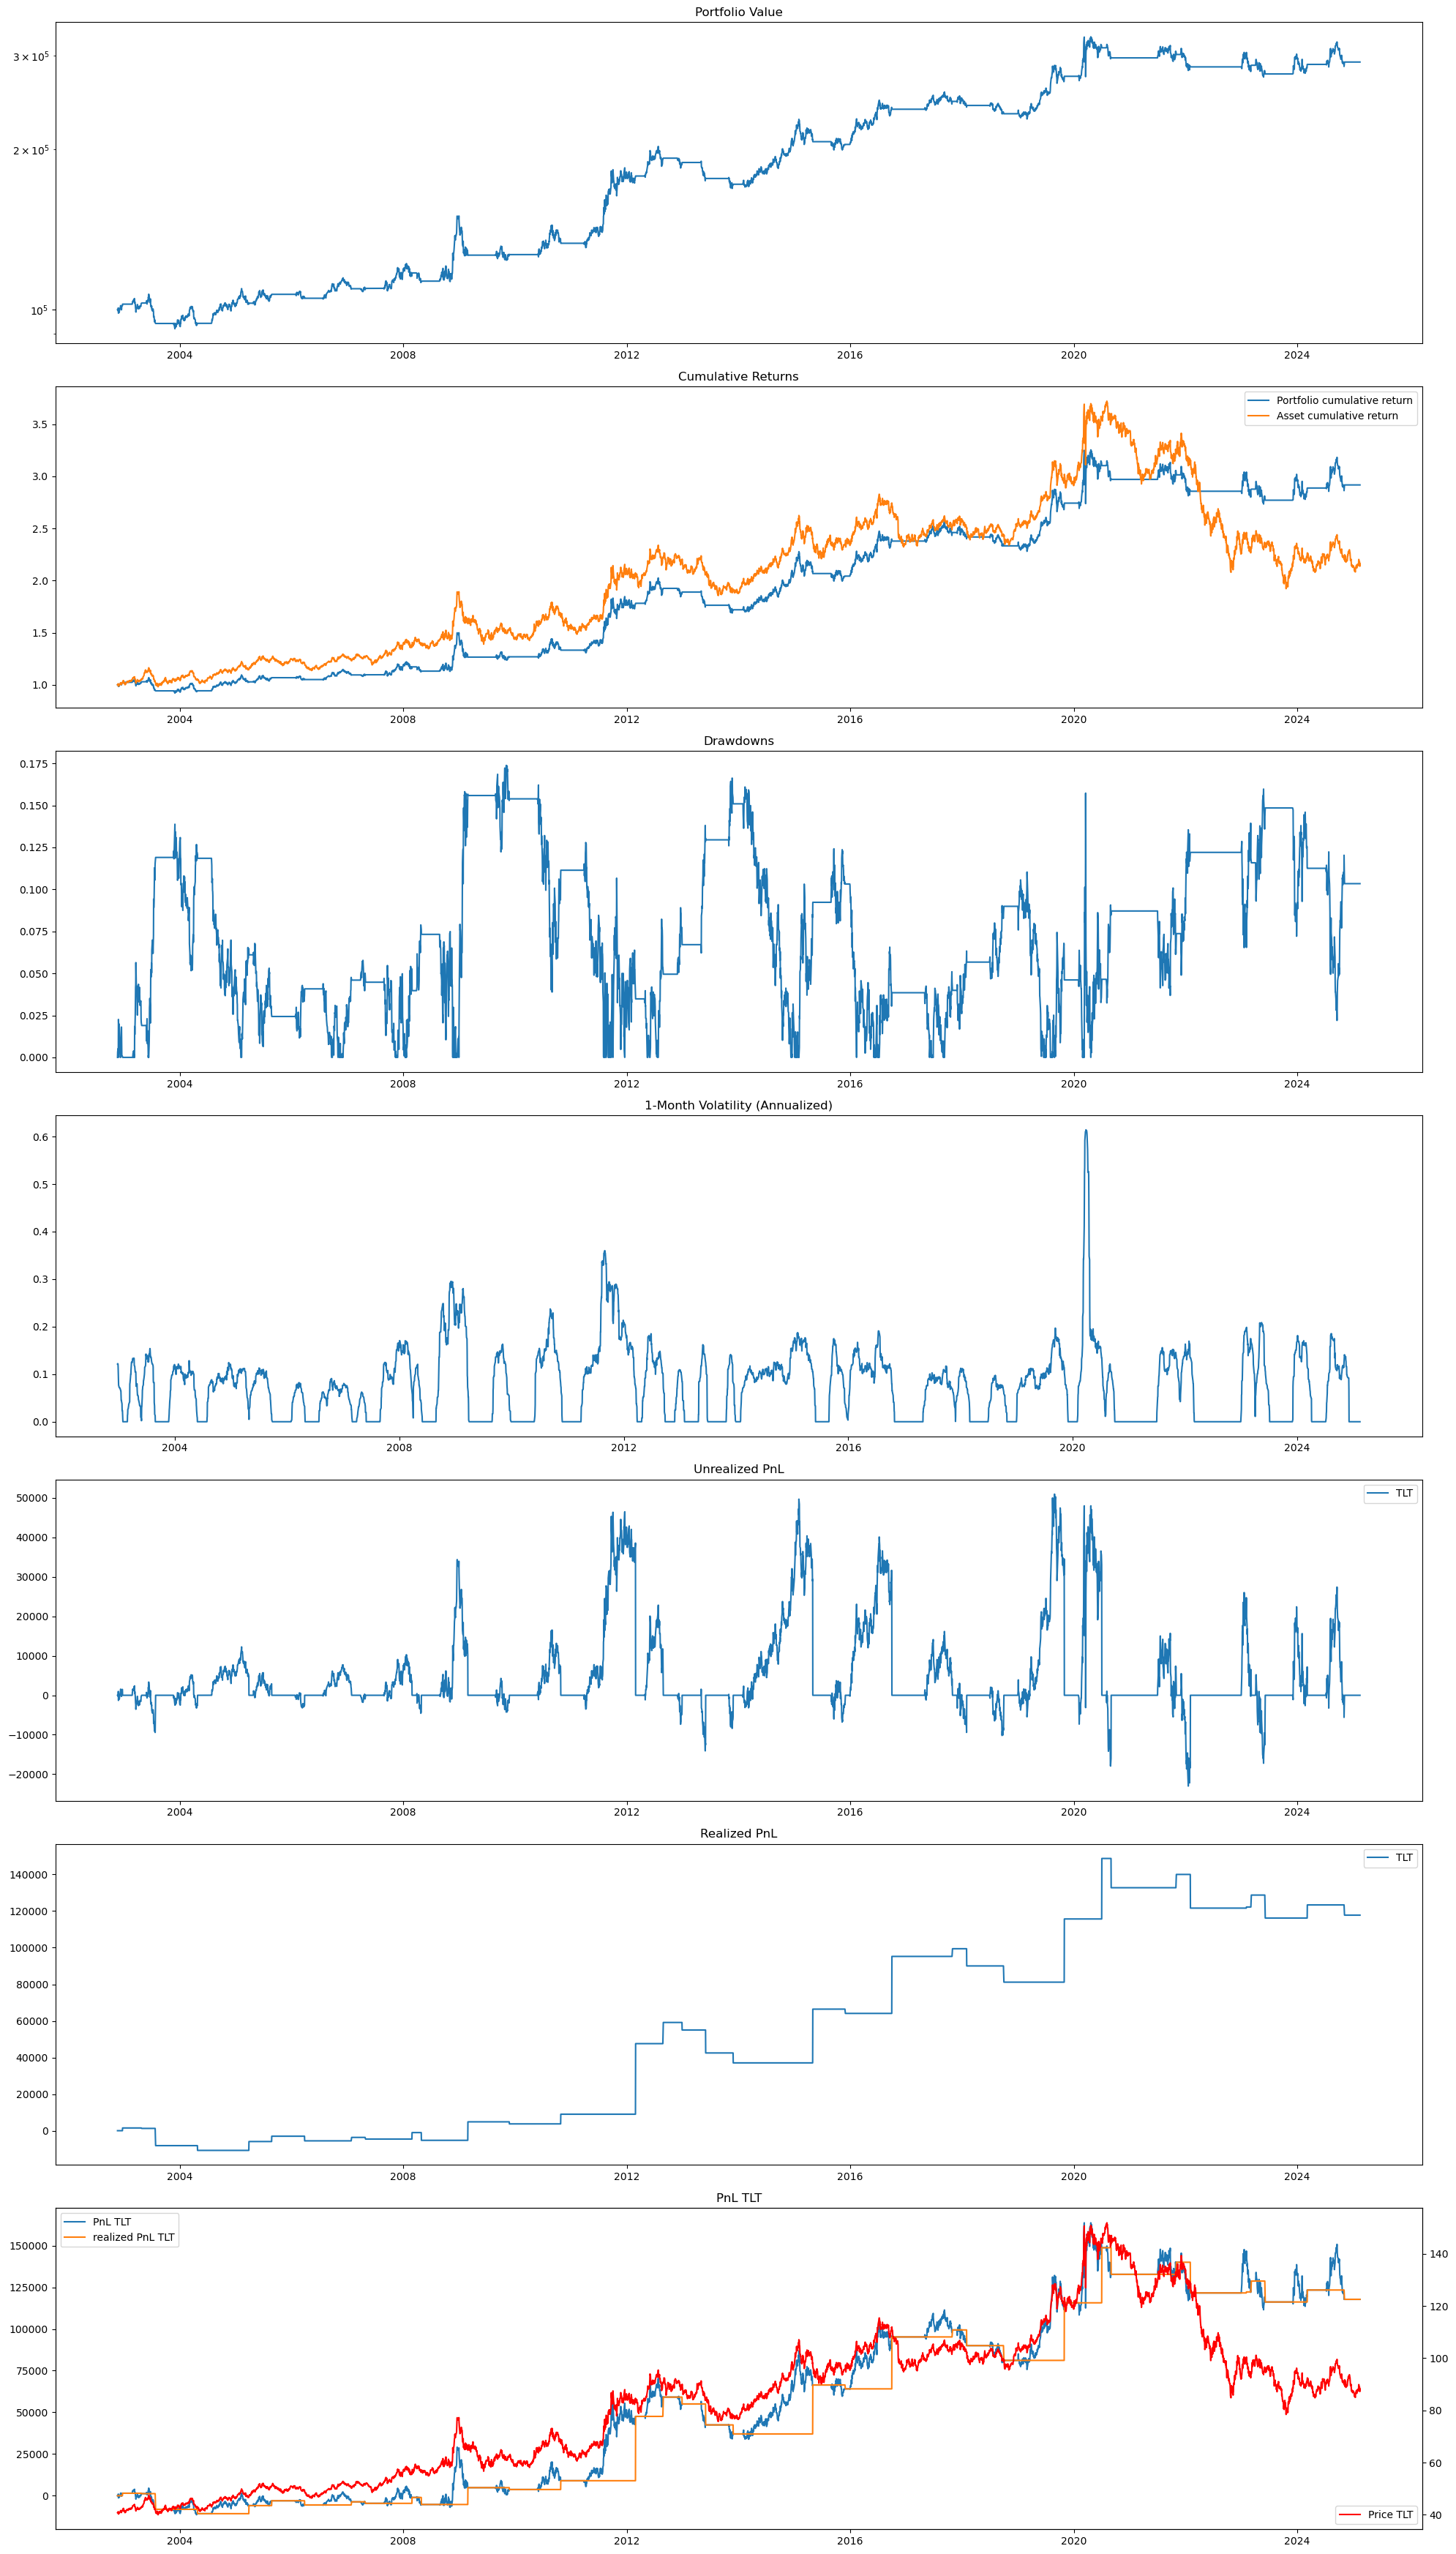

In [44]:
returns_logs['oracle'] = dict()
for ticker in ticker_list:
    df = price_data[ticker]
    print(ticker)
    best_params = oracle_params[ticker]
    print(best_params)
    results = backtest_strategy(ticker, df, short_window=best_params['short_window'], long_window=best_params['long_window'], verbose=True)
    returns_logs['oracle'][ticker] = results['returns']



## Prior period optimization

In [45]:
from sklearn.model_selection import TimeSeriesSplit
# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

prior_period_opt_logs = dict()
for ticker in tqdm(ticker_list):

    prior_period_opt_logs[ticker] = []
    df = price_data[ticker]

    # Perform cross-validation splits
    for train_index, test_index in tscv.split(df):
        train = df.iloc[train_index]
        test = df.iloc[test_index]
        print("Training set size:", len(train), "Testing set size:", len(test))

        # Fit the model on the training set
        best_params = optimize_params(ticker, train, 100)

        results = backtest_strategy(ticker, test, short_window=best_params['short_window'], long_window=best_params['long_window'])

        prior_period_opt_logs[ticker].append({
            'short_window': best_params['short_window'],
            'long_window': best_params['long_window'],
            'results': results,
        })
    



        



  0%|          | 0/3 [00:00<?, ?it/s]

[I 2025-02-22 21:00:19,218] A new study created in memory with name: no-name-5c6a415d-1cfd-415a-8df4-faddba303ba4


Training set size: 1347 Testing set size: 1344


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:00:19,227] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:00:19,812] Trial 1 finished with value: 1.881389474775626 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 1.881389474775626.
[I 2025-02-22 21:00:20,458] Trial 2 finished with value: 1.4287867504300364 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 1.881389474775626.
[I 2025-02-22 21:00:20,460] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 1.881389474775626.
[I 2025-02-22 21:00:21,046] Trial 4 finished with value: 1.802922872559564 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 1 with value: 1.881389474775626.
[I 2025-02-22 21:00:21,048] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is trial 1

[I 2025-02-22 21:01:14,748] A new study created in memory with name: no-name-af108552-e0bf-4db7-8519-a19869edd7a1


Training set size: 2691 Testing set size: 1344


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:01:14,757] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:01:16,009] Trial 1 finished with value: 0.8218231208133046 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.8218231208133046.
[I 2025-02-22 21:01:17,357] Trial 2 finished with value: 0.6149553506418851 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.8218231208133046.
[I 2025-02-22 21:01:17,359] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.8218231208133046.
[I 2025-02-22 21:01:18,618] Trial 4 finished with value: 0.8653904092850477 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 0.8653904092850477.
[I 2025-02-22 21:01:18,621] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is t

[I 2025-02-22 21:03:18,068] A new study created in memory with name: no-name-4dd59c16-fde7-49f5-9368-93abf6b19674


Training set size: 4035 Testing set size: 1344


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:03:18,076] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:03:20,006] Trial 1 finished with value: 0.7526988681558632 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.7526988681558632.
[I 2025-02-22 21:03:22,016] Trial 2 finished with value: 0.594763361940201 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.7526988681558632.
[I 2025-02-22 21:03:22,018] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.7526988681558632.
[I 2025-02-22 21:03:24,008] Trial 4 finished with value: 0.7698963235082851 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 0.7698963235082851.
[I 2025-02-22 21:03:24,010] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is tr

[I 2025-02-22 21:06:29,121] A new study created in memory with name: no-name-14c01f8c-e508-41e6-802f-77ad94b2e42d


Training set size: 5379 Testing set size: 1344


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:06:29,128] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:06:31,739] Trial 1 finished with value: 0.7664434208656543 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.7664434208656543.
[I 2025-02-22 21:06:34,380] Trial 2 finished with value: 0.7678359761382207 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.7678359761382207.
[I 2025-02-22 21:06:34,383] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.7678359761382207.
[I 2025-02-22 21:06:37,052] Trial 4 finished with value: 0.7937567481466541 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 0.7937567481466541.
[I 2025-02-22 21:06:37,055] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is t

[I 2025-02-22 21:10:44,307] A new study created in memory with name: no-name-fdac03b7-18fd-44f7-a56a-475dfb5561ab


Training set size: 6723 Testing set size: 1344


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:10:44,315] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:10:47,764] Trial 1 finished with value: 0.702499075644845 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.702499075644845.
[I 2025-02-22 21:10:51,244] Trial 2 finished with value: 0.697595107222634 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.702499075644845.
[I 2025-02-22 21:10:51,246] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.702499075644845.
[I 2025-02-22 21:10:54,609] Trial 4 finished with value: 0.7459089105757674 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 0.7459089105757674.
[I 2025-02-22 21:10:54,612] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is trial 

[I 2025-02-22 21:16:05,968] A new study created in memory with name: no-name-519e5c9e-4835-40a6-8b83-69fa0bd05b02


Training set size: 852 Testing set size: 848


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:16:05,977] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:16:06,301] Trial 1 finished with value: 1.0284739253653719 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 1.0284739253653719.
[I 2025-02-22 21:16:06,691] Trial 2 finished with value: 1.207481871075054 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 1.207481871075054.
[I 2025-02-22 21:16:06,693] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 1.207481871075054.
[I 2025-02-22 21:16:07,017] Trial 4 finished with value: 1.2497487815362123 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 1.2497487815362123.
[I 2025-02-22 21:16:07,020] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is tria

[I 2025-02-22 21:16:36,520] A new study created in memory with name: no-name-c52a9b5f-6fb3-4d91-aee1-545292766cf1


Training set size: 1700 Testing set size: 848


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:16:36,528] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:16:37,316] Trial 1 finished with value: 1.027849193940337 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 1.027849193940337.
[I 2025-02-22 21:16:38,135] Trial 2 finished with value: 1.1772571537935026 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 1.1772571537935026.
[I 2025-02-22 21:16:38,137] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 1.1772571537935026.
[I 2025-02-22 21:16:38,939] Trial 4 finished with value: 1.0442243557163513 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 1.1772571537935026.
[I 2025-02-22 21:16:38,942] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is tri

[I 2025-02-22 21:17:45,948] A new study created in memory with name: no-name-3721763d-cc9b-4606-bb63-ab0900bf1278


Training set size: 2548 Testing set size: 848


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:17:45,958] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:17:47,096] Trial 1 finished with value: 0.5784436332650645 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.5784436332650645.
[I 2025-02-22 21:17:48,363] Trial 2 finished with value: 0.6113249586780909 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.6113249586780909.
[I 2025-02-22 21:17:48,365] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.6113249586780909.
[I 2025-02-22 21:17:49,534] Trial 4 finished with value: 0.5551286236757391 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.6113249586780909.
[I 2025-02-22 21:17:49,537] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is t

[I 2025-02-22 21:19:37,281] A new study created in memory with name: no-name-0995d1ee-3365-41c1-8da3-9be6de85ed61


Training set size: 3396 Testing set size: 848


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:19:37,289] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:19:38,876] Trial 1 finished with value: 0.45031588599914707 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.45031588599914707.
[I 2025-02-22 21:19:40,499] Trial 2 finished with value: 0.3936287071351801 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.45031588599914707.
[I 2025-02-22 21:19:40,502] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.45031588599914707.
[I 2025-02-22 21:19:42,156] Trial 4 finished with value: 0.4506492559933266 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 4 with value: 0.4506492559933266.
[I 2025-02-22 21:19:42,159] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best 

[I 2025-02-22 21:21:58,785] A new study created in memory with name: no-name-14326eb3-6fc7-4a5e-8dff-d9563b1474b9


Training set size: 4244 Testing set size: 848


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:21:58,793] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:22:00,852] Trial 1 finished with value: 0.43402536941380165 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.43402536941380165.
[I 2025-02-22 21:22:02,956] Trial 2 finished with value: 0.45792785698900196 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.45792785698900196.
[I 2025-02-22 21:22:02,959] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.45792785698900196.
[I 2025-02-22 21:22:04,960] Trial 4 finished with value: 0.4399533421787074 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.45792785698900196.
[I 2025-02-22 21:22:04,962] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Bes

[I 2025-02-22 21:25:15,963] A new study created in memory with name: no-name-46e8213f-b9df-40a0-98dc-48429d521b74


Training set size: 949 Testing set size: 945


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:25:15,974] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:25:16,355] Trial 1 finished with value: 0.2000473084245274 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.2000473084245274.
[I 2025-02-22 21:25:16,810] Trial 2 finished with value: -0.10001332429576462 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.2000473084245274.
[I 2025-02-22 21:25:16,811] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.2000473084245274.
[I 2025-02-22 21:25:17,187] Trial 4 finished with value: -0.01327689264404811 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 1 with value: 0.2000473084245274.
[I 2025-02-22 21:25:17,190] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best 

[I 2025-02-22 21:25:53,862] A new study created in memory with name: no-name-650bbb23-8e86-4b15-9ba4-b5e09ea6f342


Training set size: 1894 Testing set size: 945


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:25:53,871] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:25:54,702] Trial 1 finished with value: 0.308996246252228 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.308996246252228.
[I 2025-02-22 21:25:55,571] Trial 2 finished with value: 0.21761753765425854 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 1 with value: 0.308996246252228.
[I 2025-02-22 21:25:55,573] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 1 with value: 0.308996246252228.
[I 2025-02-22 21:25:56,398] Trial 4 finished with value: 0.2417474482097887 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 1 with value: 0.308996246252228.
[I 2025-02-22 21:25:56,400] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best is trial

[I 2025-02-22 21:27:13,500] A new study created in memory with name: no-name-0bae1e3b-e106-4add-8f7b-8939bf8047e7


Training set size: 2839 Testing set size: 945


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:27:13,507] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:27:14,812] Trial 1 finished with value: 0.10404595550742032 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.10404595550742032.
[I 2025-02-22 21:27:16,218] Trial 2 finished with value: 0.16355488631819876 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.16355488631819876.
[I 2025-02-22 21:27:16,221] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.16355488631819876.
[I 2025-02-22 21:27:17,555] Trial 4 finished with value: 0.12653841799783289 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.16355488631819876.
[I 2025-02-22 21:27:17,558] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Be

[I 2025-02-22 21:29:23,298] A new study created in memory with name: no-name-81bb30ec-3e3e-4623-adee-8d2e3f80fe97


Training set size: 3784 Testing set size: 945


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:29:23,307] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:29:25,043] Trial 1 finished with value: 0.061972013883782914 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.061972013883782914.
[I 2025-02-22 21:29:26,849] Trial 2 finished with value: 0.22656085898668094 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.22656085898668094.
[I 2025-02-22 21:29:26,851] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.22656085898668094.
[I 2025-02-22 21:29:28,583] Trial 4 finished with value: 0.12371831934996183 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.22656085898668094.
[I 2025-02-22 21:29:28,586] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. 

[I 2025-02-22 21:32:10,776] A new study created in memory with name: no-name-6ac97b76-8a33-4d82-a770-347c3a397051


Training set size: 4729 Testing set size: 945


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-02-22 21:32:10,784] Trial 0 finished with value: -1.0 and parameters: {'long_window': 218, 'short_window': 240}. Best is trial 0 with value: -1.0.
[I 2025-02-22 21:32:13,088] Trial 1 finished with value: 0.09066356303621598 and parameters: {'long_window': 380, 'short_window': 153}. Best is trial 1 with value: 0.09066356303621598.
[I 2025-02-22 21:32:15,390] Trial 2 finished with value: 0.2678619438137163 and parameters: {'long_window': 120, 'short_window': 43}. Best is trial 2 with value: 0.2678619438137163.
[I 2025-02-22 21:32:15,392] Trial 3 finished with value: -1.0 and parameters: {'long_window': 76, 'short_window': 219}. Best is trial 2 with value: 0.2678619438137163.
[I 2025-02-22 21:32:17,670] Trial 4 finished with value: 0.12784543686251093 and parameters: {'long_window': 321, 'short_window': 180}. Best is trial 2 with value: 0.2678619438137163.
[I 2025-02-22 21:32:17,672] Trial 5 finished with value: -1.0 and parameters: {'long_window': 59, 'short_window': 245}. Best i

### Results

In [46]:
# display(prior_period_opt_logs)

returns_logs['prior_period_opt'] = dict()
for ticker in ticker_list:
    # stitch together the returns
    ticker_returns = pd.DataFrame()
    for log in prior_period_opt_logs[ticker]:
        
        ticker_returns = pd.concat([ticker_returns, log['results']['returns']], axis=0)
    
    returns_logs['prior_period_opt'][ticker] = ticker_returns

In [47]:
for method in returns_logs:
    for ticker in returns_logs[method]:
        returns_logs[method][ticker].to_csv(f"./logs/{method}_{ticker}.csv")

## Comparison

2000-04-11 00:00:00 2025-02-13 00:00:00
buy_hold SPY CAGR: 0.08, Volatility: 0.19, Sharpe Ratio: 0.40
reference_SMA SPY CAGR: 0.08, Volatility: 0.13, Sharpe Ratio: 0.63
oracle SPY CAGR: 0.08, Volatility: 0.14, Sharpe Ratio: 0.59
prior_period_opt SPY CAGR: 0.06, Volatility: 0.13, Sharpe Ratio: 0.49


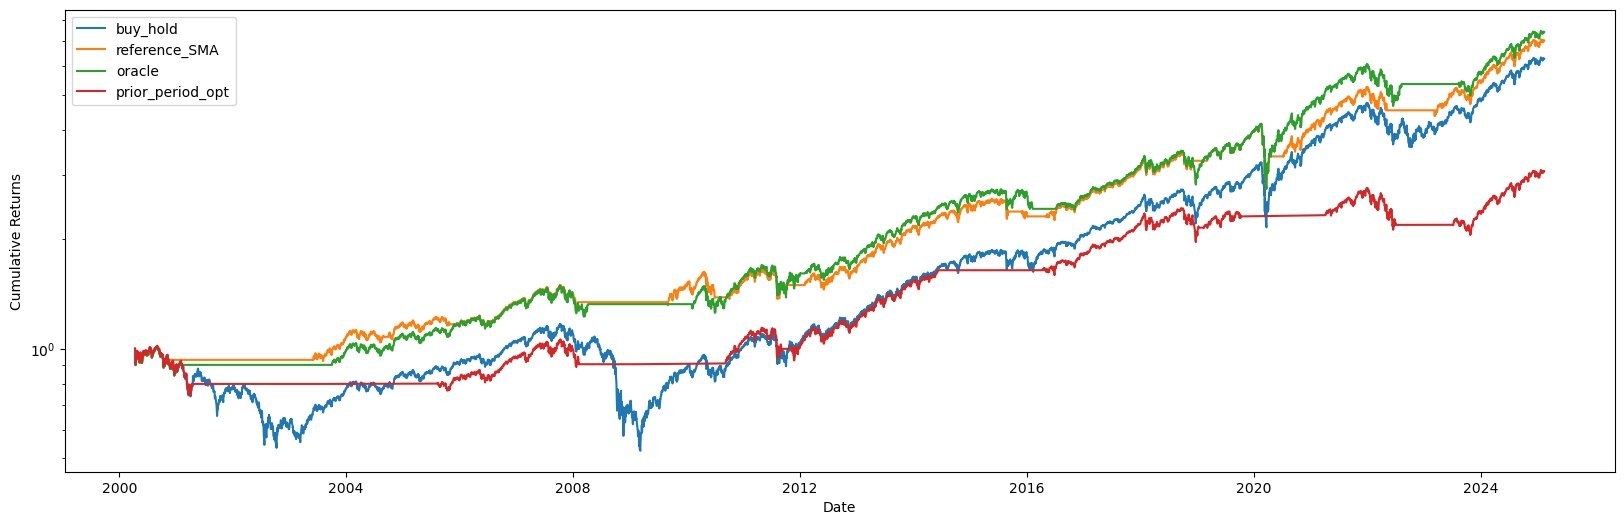

2010-02-26 00:00:00 2025-02-13 00:00:00
buy_hold GLD CAGR: 0.06, Volatility: 0.15, Sharpe Ratio: 0.41
reference_SMA GLD CAGR: 0.05, Volatility: 0.12, Sharpe Ratio: 0.45
oracle GLD CAGR: 0.08, Volatility: 0.12, Sharpe Ratio: 0.65
prior_period_opt GLD CAGR: 0.08, Volatility: 0.12, Sharpe Ratio: 0.73


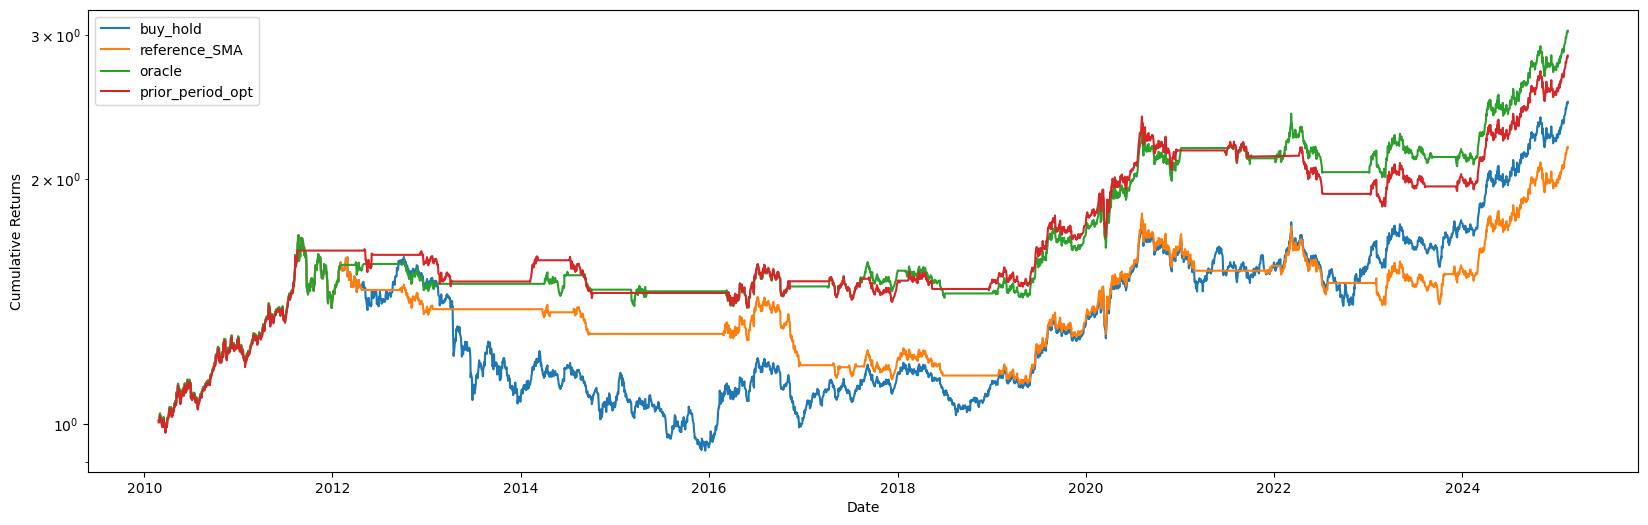

2007-06-06 00:00:00 2025-02-13 00:00:00
buy_hold TLT CAGR: 0.03, Volatility: 0.16, Sharpe Ratio: 0.21
reference_SMA TLT CAGR: 0.02, Volatility: 0.11, Sharpe Ratio: 0.21
oracle TLT CAGR: 0.06, Volatility: 0.11, Sharpe Ratio: 0.50
prior_period_opt TLT CAGR: 0.00, Volatility: 0.12, Sharpe Ratio: 0.04


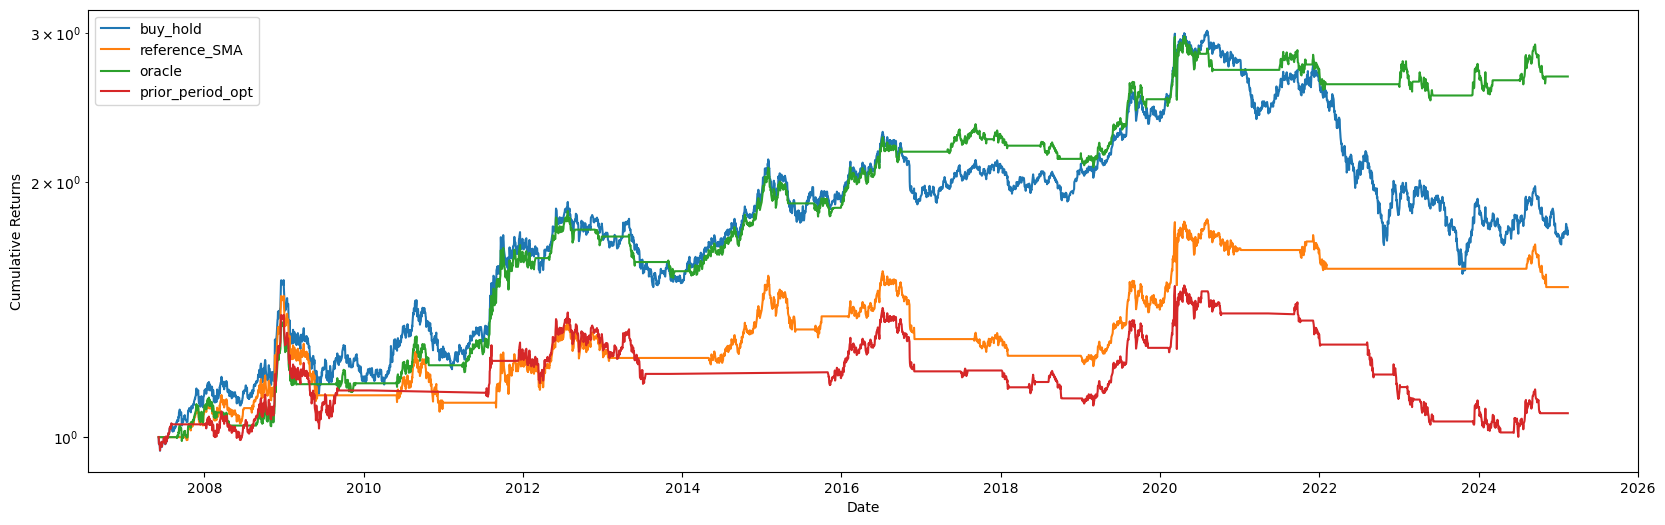

In [59]:
for ticker in ticker_list:
    start_date = None
    end_date = None
    for method in returns_logs:
        df = returns_logs[method][ticker].copy()

        if start_date is None:
            start_date = df.index[0]
        if end_date is None:
            end_date = df.index[-1]
        if df.index[0] > start_date or start_date is None:
            start_date = df.index[0]
        if df.index[-1] < end_date:
            end_date = df.index[-1]

    print(start_date, end_date)
    plt.figure(figsize=(20, 6))
    for method in returns_logs:
        df = returns_logs[method][ticker].copy()
        df = df.loc[start_date:end_date]
        df['cumulative_returns'] = (1 + df['returns']).cumprod()
        cagr = (df['cumulative_returns'][-1] ** (252 / len(df))) - 1
        vol = df['returns'].std() * np.sqrt(252)
        sharpe_ratio = cagr / vol

        print(f'{method} {ticker} CAGR: {cagr:.2f}, Volatility: {vol:.2f}, Sharpe Ratio: {sharpe_ratio:.2f}')
        
        plt.plot(df['cumulative_returns'], label=f'{method}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.yscale('log')
    plt.legend()
    plt.show()



        


We note that optimizing the window for the moving average using historical data does not perform consistently better than the other methods. This is overfitting in action. 

We note that trend following still generally outperforms buy and hold.

We should stick with reference SMA for now (long window = 252, short window = 21)

# Multi Asset Allocation

Now that we need to investigate how to allocate our capital across multiple assets.

## Generate weights with HRP

In [60]:
import pandas as pd
from pypfopt import HRPOpt

def hierarchical_risk_parity_allocation(asset_dfs):
    """
    Perform Hierarchical Risk Parity (HRP) asset allocation given multiple dataframes of asset returns.

    Parameters:
    asset_dfs (list of pd.DataFrame): List of dataframes, each containing 'dates' and 'returns' columns.

    Returns:
    dict: Asset allocation weights with generated asset names as keys.
    """
    processed_series = []
    
    # Process each asset dataframe to create return series with unique names
    for ticker in asset_dfs:
        df = asset_dfs[ticker].copy()
        # df['date'] = pd.to_datetime(df['date'])
        # df.set_index('date', inplace=True)
        df = df[~df.index.duplicated(keep='first')]  # Remove duplicate dates
        asset_name = ticker
        processed_series.append(df['returns'].rename(asset_name))
    
    # Combine all series into a single dataframe with inner join
    combined_df = pd.concat(processed_series, axis=1, join='inner')

    display(combined_df)
    
    if combined_df.empty:
        raise ValueError("No common dates found across all assets")
    
    # Calculate HRP weights
    hrp = HRPOpt(combined_df)
    hrp_weights = hrp.optimize()
    
    return hrp_weights


hrp_weights = hierarchical_risk_parity_allocation(returns_logs['reference_SMA'])
print(hrp_weights)

SPY       GLD  TLT
date                               
2005-11-17  0.000000  0.005211  0.0
2005-11-18  0.000000 -0.000416  0.0
2005-11-21  0.000000  0.011040  0.0
2005-11-22  0.000000  0.006799  0.0
2005-11-23  0.000000 -0.003479  0.0
...              ...       ...  ...
2025-02-07 -0.009153  0.001784  0.0
2025-02-10  0.006791  0.016938  0.0
2025-02-11  0.000761 -0.003652  0.0
2025-02-12 -0.003222  0.001047  0.0
2025-02-13  0.001641  0.004782  0.0

[4840 rows x 3 columns]

OrderedDict([('GLD', 0.2495925551529987), ('SPY', 0.30508381159257847), ('TLT', 0.4453236332544228)])


### Test portfolio

Trend following Results: {'cagr': 0.060206052427518086, 'volatility': 0.07051943563718618, 'sharpe': 0.8537511947382962, 'max_drawdown': 0.14791961771513112, 'cumulative_returns': 2.0743642632032167}


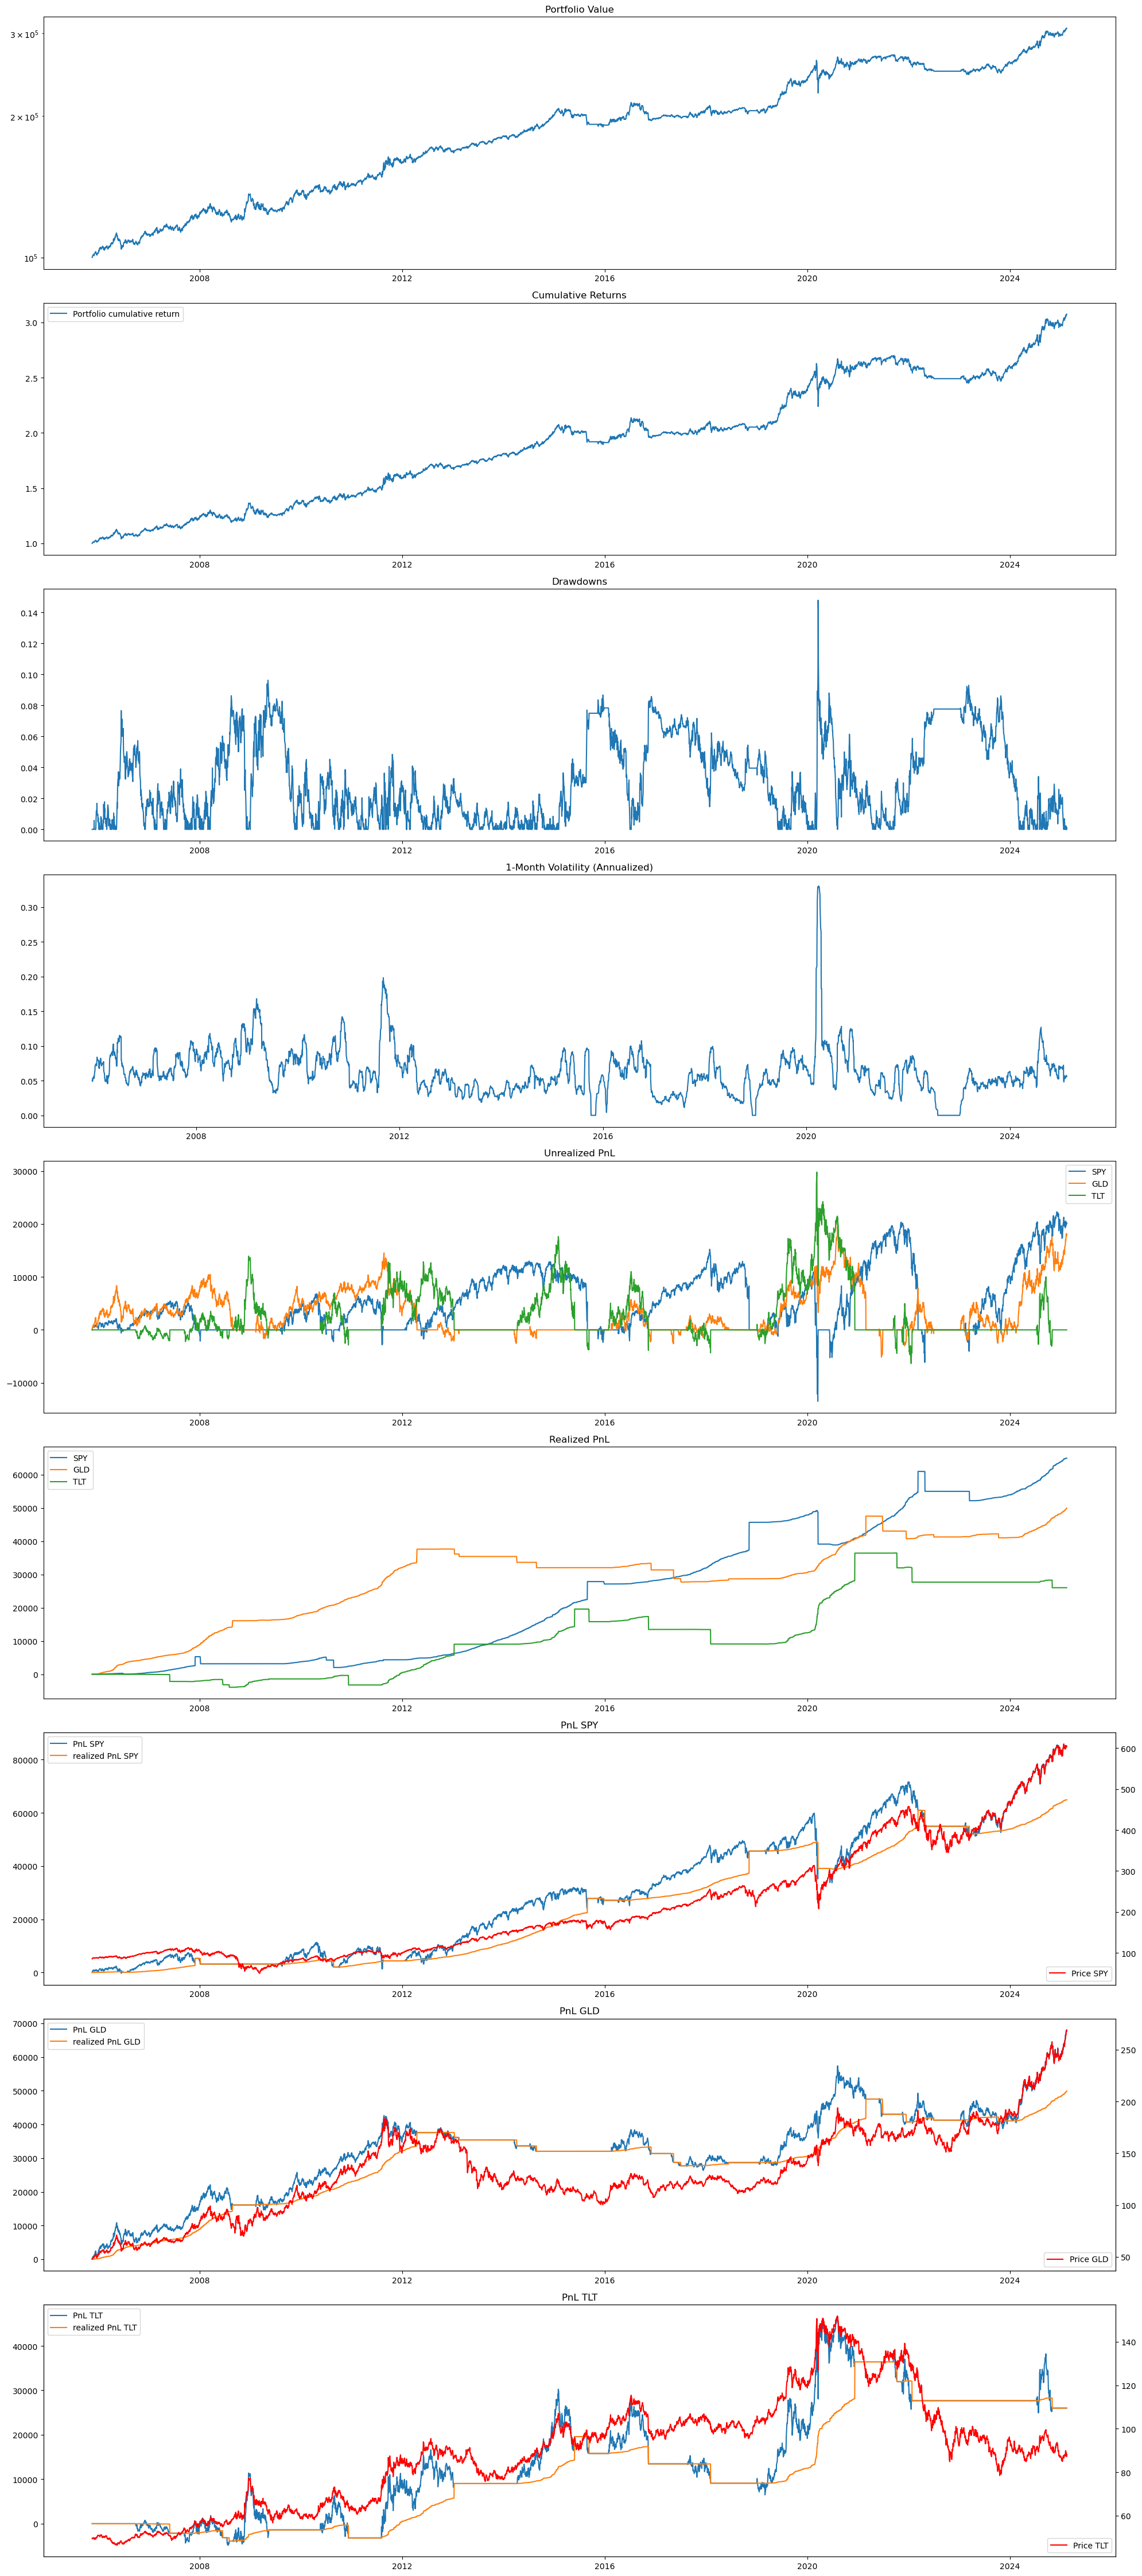

In [61]:
from strategies.trend_following import MultiAssetMovingAverageCrossoverStrategy

tl = ['SPY', 'GLD', 'TLT']
pda = {t: price_data[t] for t in tl}
bt = BackTester(pda)
bt.add_strategy(MultiAssetMovingAverageCrossoverStrategy, tickers=tl, price_data=pda, ticker_list=tl, short_window=21, long_window=252, rebalance_period=1, weights=hrp_weights)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()


In [62]:
bt.show_final_positions(current_capital=63115, leverage=2)

Final Positions on date: 2025-02-13 00:00:00
SPY
Position weight:    30.51%
Expected size:      63
Current price:      $604.3499755859375
Position value:     $38074.05
GLD
Position weight:    25.04%
Expected size:      117
Current price:      $268.9501037597656
Position value:     $31467.16
TLT
Position weight:    0.00%
Expected size:      0
Current price:      $88.19860076904297
Position value:     $0.00


6.760631413893938


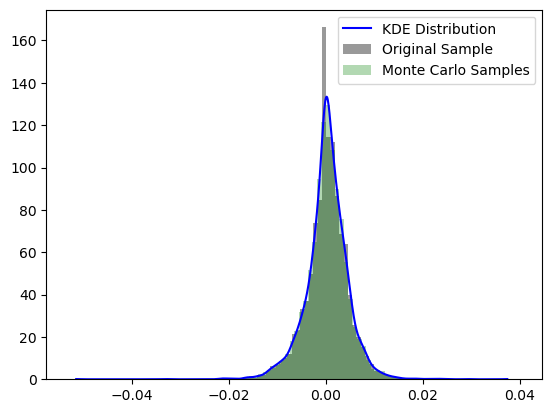

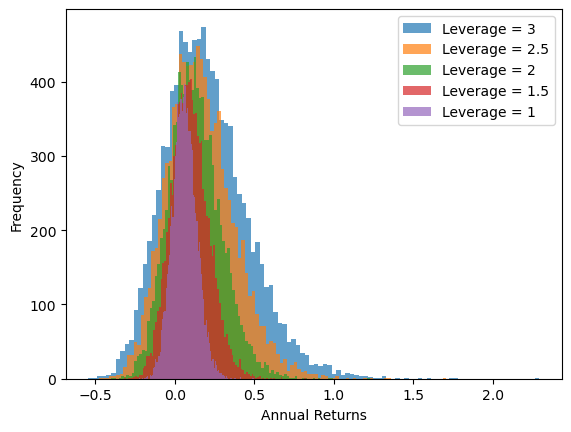

Max median return: 0.42, optimal leverage: 11.00


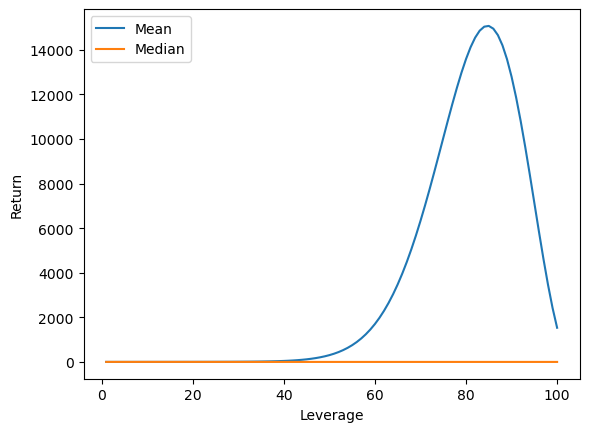

In [ ]:
from scipy.stats import gaussian_kde
allowable_leverage_from_max_drawdown = 1 / results['max_drawdown']
print(allowable_leverage_from_max_drawdown)

ret_arr = results['returns'].to_list()
ret_arr = np.array(ret_arr)
ret_arr

kde = gaussian_kde(ret_arr)
num_samples = 10000
monte_carlo_samples = kde.resample(num_samples)[0]

x_vals = np.linspace(min(ret_arr), max(ret_arr), 1000)
kde_vals = kde(x_vals)

plt.plot(x_vals, kde_vals, color='blue', label='KDE Distribution')
plt.hist(ret_arr, bins=100, density=True, alpha=0.4, color='black', label='Original Sample')
plt.hist(monte_carlo_samples, bins=100, density=True, alpha=0.3, color='green', label='Monte Carlo Samples')
plt.legend()
plt.show()

num_trials = 10000
trial_length = 252

trials = []
for i in range(num_trials):
    monte_carlo_samples = kde.resample(trial_length)[0]
    trials.append(monte_carlo_samples)
trials = np.array(trials)

for leverage in [3, 2.5, 2, 1.5, 1]:
    returns = np.prod(1 + trials * leverage, axis=1) - 1

    plt.hist(returns, bins=100, label=f'Leverage = {leverage}', alpha=0.7)

plt.xlabel('Annual Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()


leverage_arr = []
median_ret_arr = []
mean_ret_arr = []


for leverage in np.linspace(1, 100, 100):
    returns = np.prod(1 + trials * leverage, axis=1) - 1

    leverage_arr.append(leverage)
    mean_ret_arr.append(np.mean(returns))
    median_ret_arr.append(np.median(returns))

print(f"Max median return: {np.max(median_ret_arr) :.2f}, optimal leverage: {leverage_arr[np.argmax(median_ret_arr)] :.2f}")

plt.plot(leverage_arr, mean_ret_arr, label='Mean')
plt.plot(leverage_arr, median_ret_arr, label='Median')
plt.xlabel('Leverage')
plt.ylabel('Return')
plt.legend()
plt.show()

# Optuna optimization

In [ ]:
import optuna

def objective(trial):
    test_weights = {
        "SPY": trial.suggest_float("SPY", 0, 1),
        "GLD": trial.suggest_float("GLD", 0, 1),
        "TLT": trial.suggest_float("TLT", 0, 1),
    }

    tl = ['SPY', 'GLD', 'TLT']
    pda = {t: price_data[t] for t in tl}
    bt = BackTester(pda)
    bt.add_strategy(MultiAssetMovingAverageCrossoverStrategy, tickers=tl, price_data=pda, ticker_list=tl, short_window=21, long_window=252, rebalance_period=21, weights=test_weights)
    results = bt.backtest()
    # print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
    # bt.plot_results()
    return results['cagr'] / results['max_drawdown']

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)


[I 2025-02-09 17:50:25,442] A new study created in memory with name: no-name-c8ad3ff7-4bf2-4068-b8e5-0ec46cdb55b3


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-02-09 17:50:32,919] Trial 0 finished with value: 0.3930291063863476 and parameters: {'SPY': 0.9171455474301484, 'GLD': 0.20636227488030212, 'TLT': 0.48030323958812216}. Best is trial 0 with value: 0.3930291063863476.
[I 2025-02-09 17:50:40,146] Trial 1 finished with value: 0.4723254054089092 and parameters: {'SPY': 0.47740108404432124, 'GLD': 0.6518550345473284, 'TLT': 0.03322368912192497}. Best is trial 1 with value: 0.4723254054089092.
[I 2025-02-09 17:50:47,651] Trial 2 finished with value: 0.4882620365050341 and parameters: {'SPY': 0.8699747144019494, 'GLD': 0.7735958601644625, 'TLT': 0.6759493420264981}. Best is trial 2 with value: 0.4882620365050341.
[I 2025-02-09 17:50:54,924] Trial 3 finished with value: 0.43812312182161445 and parameters: {'SPY': 0.2611140625294216, 'GLD': 0.8348706108403101, 'TLT': 0.2619062660399303}. Best is trial 2 with value: 0.4882620365050341.
[I 2025-02-09 17:51:02,420] Trial 4 finished with value: 0.3946721937432742 and parameters: {'SPY': 0.9

KeyboardInterrupt: 

In [ ]:
optuna_weights = study.best_params
total_weight = sum(optuna_weights.values())
for ticker in optuna_weights:
    optuna_weights[ticker] /= total_weight

print("optuna", optuna_weights)
print("hrp", hrp_weights)

optuna {'SPY': 0.3060451966746167, 'GLD': 0.5006581366748609, 'TLT': 0.19329666665052228}
hrp OrderedDict([('GLD', 0.24967966479117099), ('SPY', 0.3051344659080717), ('TLT', 0.4451858693007573)])


## Test portfolio

Trend following Results: {'cagr': 0.07409945462027778, 'volatility': 0.08670034970121442, 'sharpe': 0.8546615426078249, 'max_drawdown': 0.1468086711347462, 'cumulative_returns': 2.9412634896125103}


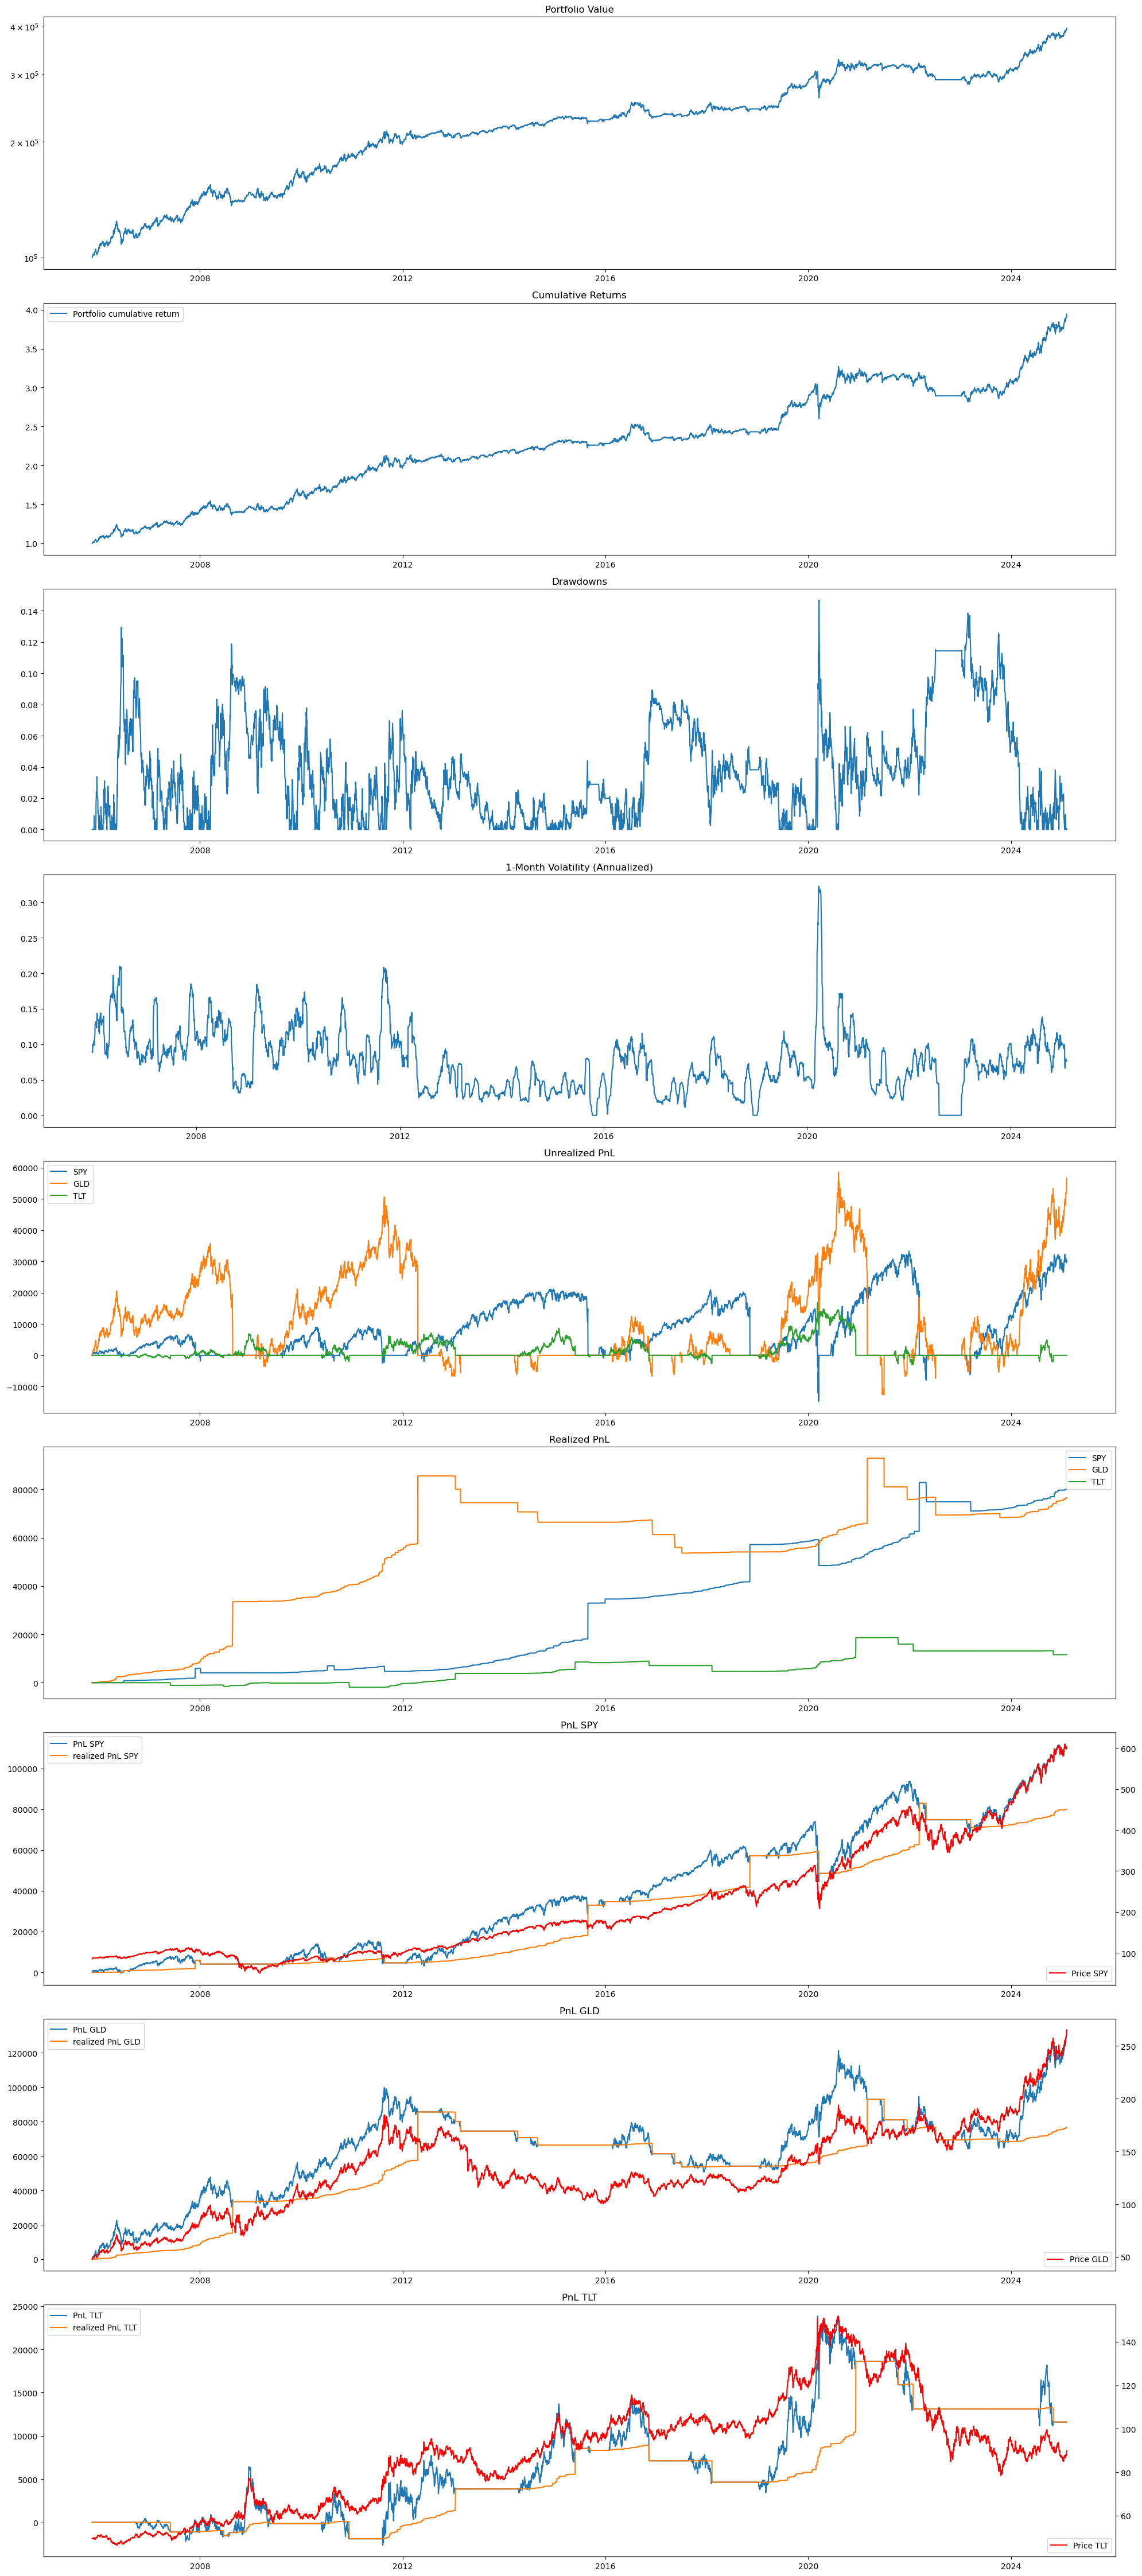

In [ ]:
tl = ['SPY', 'GLD', 'TLT']
pda = {t: price_data[t] for t in tl}
bt = BackTester(pda)
bt.add_strategy(MultiAssetMovingAverageCrossoverStrategy, tickers=tl, price_data=pda, ticker_list=tl, short_window=21, long_window=252, rebalance_period=5, weights=optuna_weights)
results = bt.backtest()
print("Trend following Results:", {k: v for k, v in results.items() if k != 'returns'})
bt.plot_results()

# END